In [1]:
from datetime import date
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import shap
shap.initjs()

In [2]:
# Make a path and folder to store results
today = date.today().strftime("%Y-%m-%d")
main_parent_dir = os.getcwd()
main_path = os.path.join(main_parent_dir, 'Results/Models/', today)

if not os.path.exists(main_path):
   os.makedirs(main_path)

Load Mushroom dataset

In [3]:
df = pd.read_csv('secondary_data.csv')

In [4]:
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


## Data preprocessing and analysis

Detecting missing values

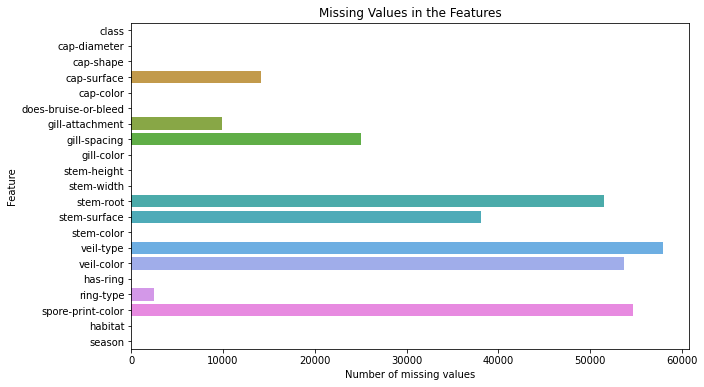

In [5]:
# Number of missing values in each column
missing_values = df.isnull().sum()

# Plot the missing values
def show_missing(df, save_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df, y=df.index)
    plt.title('Missing Values in the Features')
    plt.xlabel('Number of missing values')
    plt.ylabel('Feature')
    plt.savefig(main_path + f'/{save_name}.png', dpi=800, facecolor='w', edgecolor='w')
    plt.show()

show_missing(missing_values, "global_missing_values")

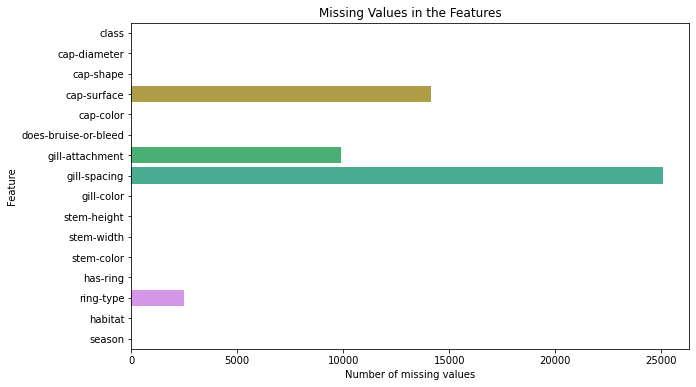

In [6]:
# Drop columns with more than half of the values missing
columns_to_drop = missing_values[missing_values > len(df)/2].index
df_drop = df.drop(columns_to_drop, axis=1)

show_missing(df_drop.isnull().sum(), "missing_values_after_drop")

In [7]:
# Replace categorical features' names with numerical values
def replace_categorical(df, column, mapping):
    df[column] = df[column].map(mapping)
    return df

class_mapping = {'e': ['Edible', 0], 'p': ['Poisonous', 1]}
cap_shape = {'b': ['bell', 0], 'c': ['conical', 1], 'x': ['convex', 2], 'f': ['flat', 3], 's': ['sunken', 4], 'p': ['spherical', 5], 'o': ['others', 6]}
cap_surface = {'i': ['fibrous', 0], 'g': ['grooves', 1], 'y': ['scaly', 2], 's': ['smooth', 3], 'h': ['shiny', 4], 'l': ['leathery', 5], 'k': ['silky', 6], 't': ['sticky', 7], 'w': ['wrinkled', 8], 'e': ['fleshy', 9]}
cap_color = {'n': ['brown', 0], 'b': ['buff', 1], 'g': ['gray', 2], 'r': ['green', 3], 'p': ['pink', 4], 'u': ['purple', 5], 'e': ['red', 6], 'w': ['white', 7], 'y': ['yellow', 8], 'l': ['blue', 9], 'o': ['orange', 10], 'k': ['black', 11]}
bruise_bleed = {'t': ['bruises-or-bleeding', 0], 'f': ['no', 1]}
gill_attachment = {'a': ['adnate', 0], 'x': ['adnexed', 1], 'd': ['decurrent', 2], 'e': ['free', 3], 's': ['sinuate', 4], 'p': ['pores', 5], 'f': ['none', 6], '?': ['unknown', 7]}
gill_spacing = {'c': ['close', 0], 'd': ['distant', 1], 'f': ['none', 2]}
gill_color = {'n': ['brown', 0], 'b': ['buff', 1], 'g': ['gray', 2], 'r': ['green', 3], 'p': ['pink', 4], 'u': ['purple', 5], 'e': ['red', 6], 'w': ['white', 7], 'y': ['yellow', 8], 'l': ['blue', 9], 'o': ['orange', 10], 'k': ['black', 11], 'f': ['none', 12]}
stem_color = {'n': ['brown', 0], 'b': ['buff', 1], 'g': ['gray', 2], 'r': ['green', 3], 'p': ['pink', 4], 'u': ['purple', 5], 'e': ['red', 6], 'w': ['white', 7], 'y': ['yellow', 8], 'l': ['blue', 9], 'o': ['orange', 10], 'k': ['black', 11], 'f': ['none', 12]}
has_ring = {'t': ['ring', 0], 'f': ['none', 1]}
ring_type = {'c': ['cobwebby', 0], 'e': ['evanescent', 1], 'r': ['flaring', 2], 'g': ['grooved', 3], 'l': ['large', 4], 'p': ['pendant', 5], 's': ['sheathing', 6], 'z': ['zone', 7], 'y': ['scaly', 8], 'm': ['movable', 9], 'f': ['none', 10], '?': ['unknown', 11]}
habitat = {'g': ['grasses', 0], 'l': ['leaves', 1], 'm': ['meadows', 2], 'p': ['paths', 3], 'h': ['heaths', 4], 'u': ['urban', 5], 'w': ['waste', 6], 'd': ['woods', 7]}
season = {'s': ['spring', 0], 'u': ['summer', 1], 'a': ['autumn', 2], 'w': ['winter', 3]}

attribute_mappings = {'class': class_mapping,
                      'cap-shape': cap_shape,
                      'cap-surface': cap_surface,
                      'cap-color': cap_color,
                      'does-bruise-or-bleed': bruise_bleed,
                      'gill-attachment': gill_attachment,
                      'gill-spacing': gill_spacing,
                      'gill-color': gill_color,
                      'stem-color': stem_color,
                      'has-ring': has_ring,
                      'ring-type': ring_type,
                      'habitat': habitat,
                      'season': season}

# Replace all categorical features with numerical values
df_num = df_drop.copy()
for column, mapping in attribute_mappings.items():
    df_num = replace_categorical(df_num, column, dict(zip(mapping.keys(), [x[1] for x in mapping.values()])))

In [8]:
missing_columns = df_num.columns[df_num.isnull().any()]
print(missing_columns)

Index(['cap-surface', 'gill-attachment', 'gill-spacing', 'ring-type'], dtype='object')


Data imputation using Random Forest

In [9]:
def RandomForestImputer(df, included_column, excluded_columns, print_performance=False, feature_importance=False):

    df_copy = df.copy()

    # Drop the excluded columns
    df_excluded = df_copy.drop(columns=excluded_columns)

    # Split the data into non-null and null datasets
    df_with_feature = df_excluded[df_excluded[included_column].notna()]

    df_no_feature = df_excluded[df_excluded[included_column].isna()]

    # Divide the data into features and labels
    X = df_with_feature.drop(included_column, axis=1).values
    y = df_with_feature[included_column].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a Random Forest classifier
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=42, max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    # Train the classifier
    forest.fit(X_train, y_train)

    # Make predictions
    y_pred_train = forest.predict(X_train)
    y_pred = forest.predict(X_test)
    y_pred_proba = forest.predict_proba(X_test)

    # Calculate the accuracy
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)

    # Print the performance metrics
    if print_performance == True:
        print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train, accuracy_test))
        print("LOG LOSS: "+ str(log_loss(y_test, y_pred_proba)))
    else:
        pass

    # Plot the feature importances
    if feature_importance == True:
        importances = forest.feature_importances_
        indices = list(np.argsort(importances))[::-1]

        plt.title("Feature importances")
        plt.barh(range(len(indices)), importances[indices], color="g", align="center")
        plt.yticks(range(len(indices)), df_with_feature.iloc[:, 1:].columns[indices])
        # plt.ylim([-1, len(indices)])
        plt.gca().invert_yaxis()
        plt.show()
    else:
        pass

    # Predict the missing values
    df_no_feature = df_no_feature.drop(included_column, axis=1)
    prediction = forest.predict(df_no_feature)

    # Insert the predicted values into the original dataframe
    df_no_feature.insert(0, included_column, prediction)
    
    # Concatenate the two dataframes
    frames = [df_with_feature, df_no_feature]
    df_final = pd.concat(frames).sort_index()
    df_final = df_final[included_column].astype(int)
    
    return df_final

In [10]:
df_feature1 = RandomForestImputer(df_num, 'cap-surface', ['gill-attachment', 'gill-spacing', 'ring-type'])
df_feature2 = RandomForestImputer(df_num, 'gill-attachment', ['cap-surface', 'gill-spacing', 'ring-type'])
df_feature3 = RandomForestImputer(df_num, 'gill-spacing', ['gill-attachment', 'cap-surface', 'ring-type'])
df_feature4 = RandomForestImputer(df_num, 'ring-type', ['gill-attachment', 'gill-spacing', 'cap-surface'])

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


In [11]:
# Replace the missing values with the predicted values
df_num['cap-surface'] = df_feature1
df_num['gill-attachment'] = df_feature2
df_num['gill-spacing'] = df_feature3
df_num['ring-type'] = df_feature4

In [12]:
# Get list of numerical and categorical features
numerical_features = df_num.select_dtypes(include=['float']).columns
categorical_features = df_num.drop(columns=numerical_features).columns

In [13]:
# Replace numerical values with actul names
df_names = df_num.copy()
for column, mapping in attribute_mappings.items():
    df_names = replace_categorical(df_names, column, dict(zip([x[1] for x in mapping.values()], [x[0] for x in mapping.values()])))

Plot the distribution of the target variable

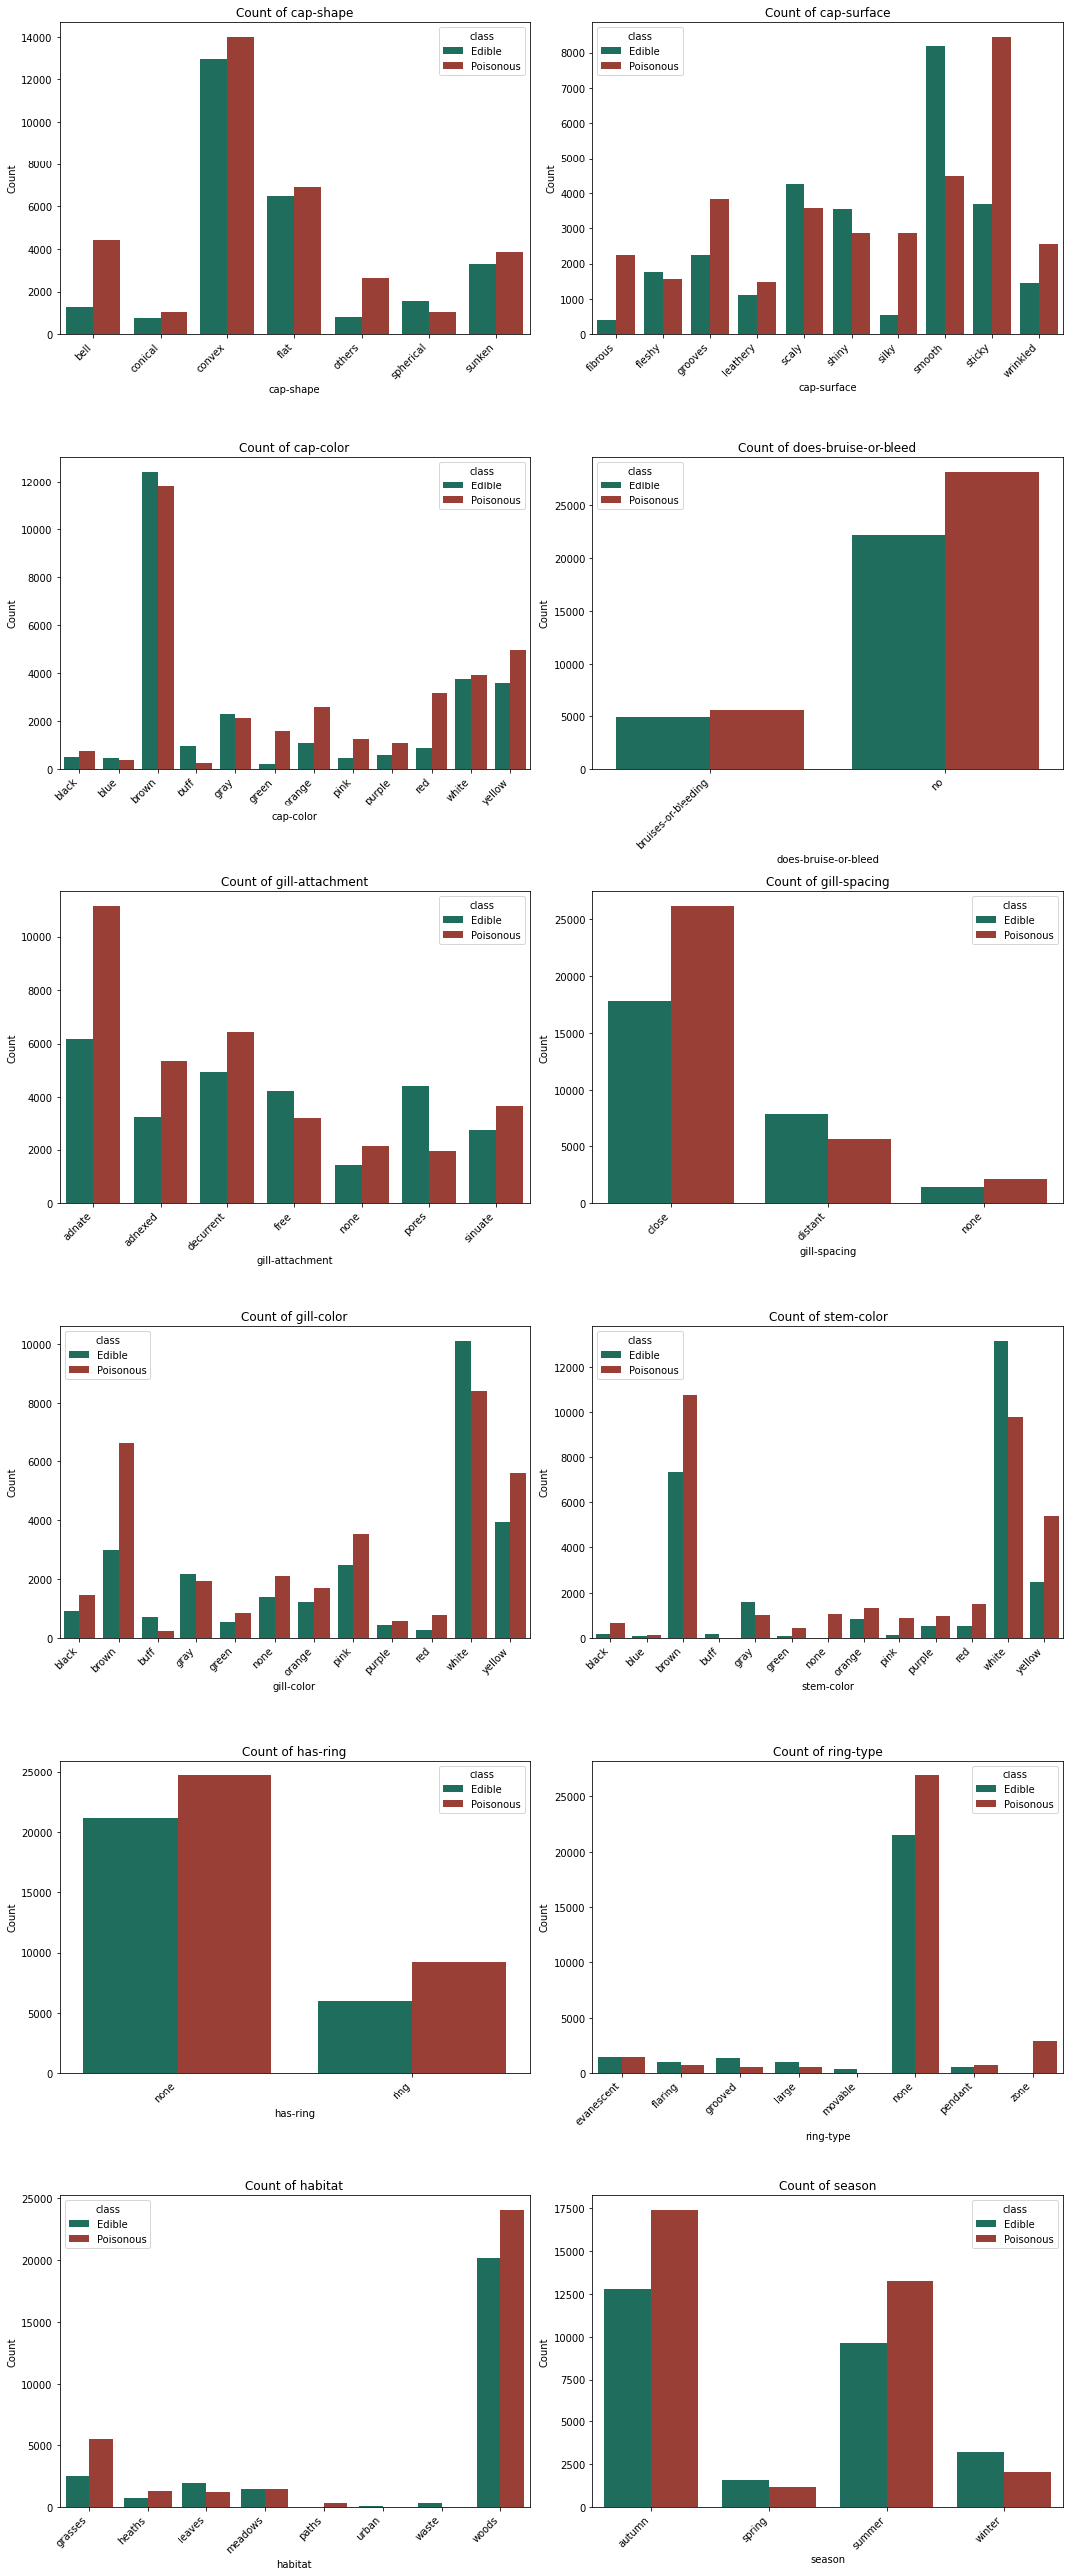

In [14]:
# Plot the count of each categorical feature

def plot_count(x, ax):
    group = df_names.groupby([f'{x}','class'])['class'].count().reset_index(name='Count')
    sns.barplot(data=group, x=x, y='Count', hue='class', palette=['#117A65', '#A93226'], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'Count of {x}')
    ax.legend(title='class')

cols = df_names[categorical_features].columns.tolist()

fig, axes = plt.subplots(len(cols)//2, 2, figsize=(15, 6 * 6))
for index, column in enumerate(cols[1:]):
    row = index // 2 
    col = index % 2
    ax = axes[row, col]
    plot_count(column, ax)
    
plt.tight_layout()
plt.savefig(main_path + '/count_categorical_features.png', dpi=800, facecolor='w', edgecolor='w')
plt.show()

1. Calculating correlation coefficient for each numerical feature
<br>
2. Calculating the Chi-Square test for each categorical feature

In [15]:
class heatmap_correlation:
    def __init__(self, df, threshold):
        self.df = df
        self.threshold = threshold

    # For numerical features
    def numeric_heatmap(df, threshold):
        sns.set_theme(style="darkgrid")
        cor_matrix = df.corr().abs()
        upper_tri = cor_matrix.where(np.tril(np.ones(cor_matrix.shape), k=-1).astype(bool))

        plt.subplots(figsize=(15, 10))
        sns.heatmap(upper_tri, vmin=-1, vmax=1, center=0, cmap=sns.cubehelix_palette(as_cmap=True), square=True, annot=True)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
        plt.title('Correlation Heatmap of the Numerical Features')
        plt.savefig(main_path + '/numerical_heatmap.png', dpi=800, facecolor='w', edgecolor='w')

        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

        print(f"High correlated numerical features which should be dropped: {to_drop}")

        if len(to_drop) == 0:
            new_df = df
            new_df = new_df.drop(columns=['class'])
            print("No features to drop")
        else:
            new_df = df.drop(columns=to_drop)
            new_df = new_df.drop(columns=['class'])
            print("Features dropped successfully")
        
        return to_drop, new_df
    
    # For categorical features
    def categorical_heatmap(df, threshold):
        # Create an empty DataFrame to store the results
        results = pd.DataFrame(index=df.columns, columns=df.columns)

        def cramers_v(confusion_matrix_):
            """ calculate Cramers V statistic for categorial-categorial association.
                uses correction from Bergsma and Wicher.
            """
            chi2 = chi2_contingency(confusion_matrix_)[0]
            n = confusion_matrix_.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix_.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

        # Calculate relationship between all pairs of categorical features
        for i in range(len(df.columns)):
            for j in range(i+1, len(df.columns)):
                feature1 = df.columns[i]
                feature2 = df.columns[j]
                
                # Crosstabulation of two categorical variables
                confusion_matrix_ = pd.crosstab(df[feature1], df[feature2])
                cross_tab = cramers_v(confusion_matrix_)
                results.loc[feature2, feature1] = cross_tab

        to_drop = [column for column in results.columns if any(results[column] > threshold)]
        print(f"High correlated categorical features which should be dropped: {to_drop}")
        
        if len(to_drop) == 0:
            new_df = df
            new_df = new_df.drop(columns=['class'])
            print("No features to drop")
        else:
            new_df = df.drop(columns=to_drop)
            new_df = new_df.drop(columns=['class'])
            print("Features dropped successfully")

        # Plot the heatmap
        plt.figure(figsize=(15, 10))
        sns.heatmap(results.astype(float), vmin=0, vmax=1, center=0, cmap=sns.cubehelix_palette(as_cmap=True), square=True, annot=True)
        plt.title('Cramers V Statistic between Categorical Features')
        plt.savefig(main_path + '/categorical_heatmap.png', dpi=800, facecolor='w', edgecolor='w')

        return to_drop, new_df

Drop feature with high correlation

High correlated numerical features which should be dropped: []
No features to drop
High correlated categorical features which should be dropped: ['gill-attachment', 'gill-spacing', 'has-ring']
Features dropped successfully


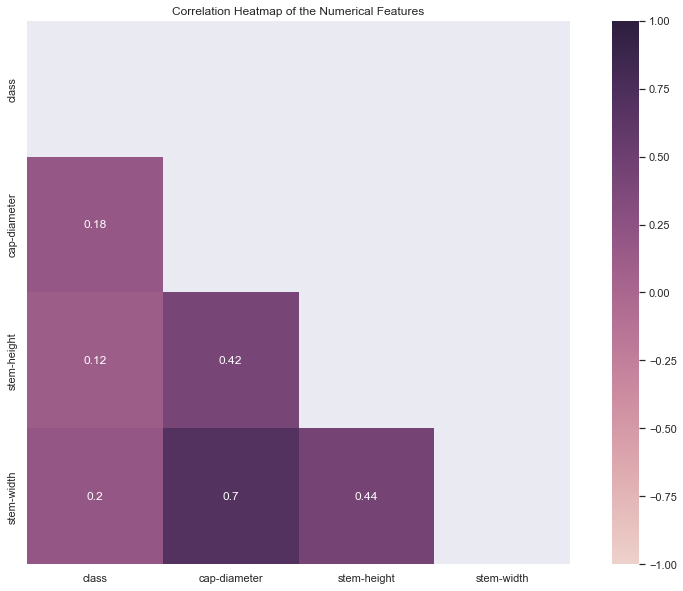

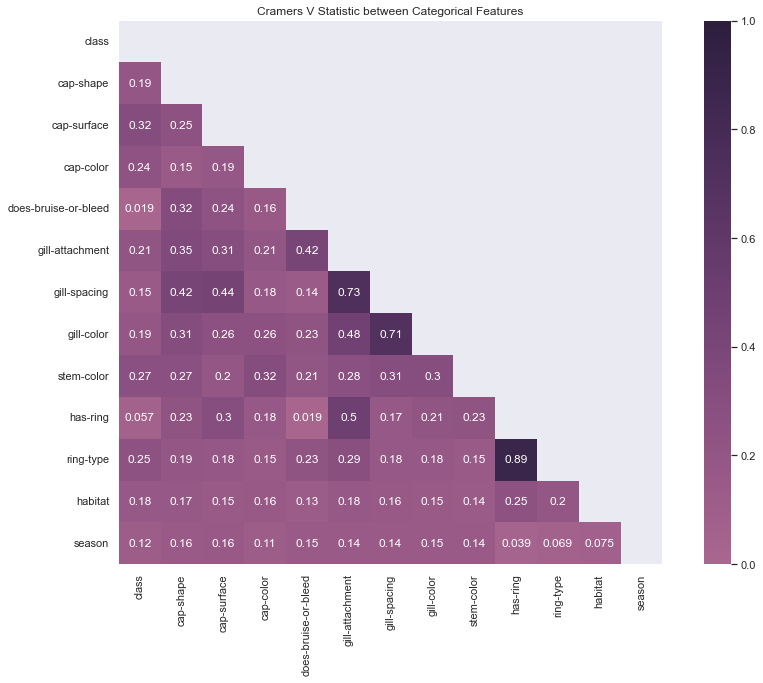

In [16]:
# Add the class column to the numerical features
numerical_features = numerical_features.insert(0, 'class')

# Correlation for numerical features
num_drop, num_new_df = heatmap_correlation.numeric_heatmap(df_num[numerical_features], 0.7)

# Correlation for categorical features
cat_drop, cat_new_df = heatmap_correlation.categorical_heatmap(df_num[categorical_features], 0.7)

Number of instances in each class

class
Poisonous    33888
Edible       27181
Name: count, dtype: int64


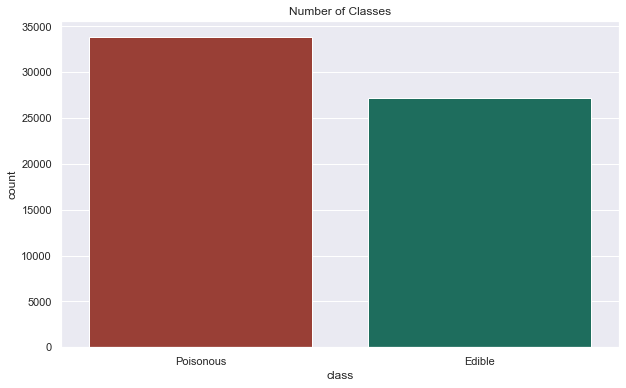

In [17]:
X = pd.concat([num_new_df, cat_new_df], axis=1)
column_list = X.columns.tolist()
y = df_num['class']
# Print the number of samples per each class
print(df_names['class'].value_counts())

# Plot the number of classes
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df_names, palette=['#A93226', '#117A65'])
plt.title('Number of Classes')
plt.savefig(main_path + '/number_of_classes.png', dpi=800, facecolor='w', edgecolor='w')
plt.show()

OneHot endcoing for categorical features

In [18]:
# OneHotEncoding
numeric_features = X.select_dtypes(include=['float']).columns
categorical_features = X.drop(columns=numeric_features).columns

for cat in categorical_features:
    one_hot = pd.get_dummies(X[cat], prefix=cat)
    X[one_hot.columns] = one_hot
final_X = X.drop(categorical_features, axis=1)

# KNN Imputation
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)], remainder='passthrough')

data_raw = pd.DataFrame(preprocessor.fit_transform(final_X), columns=final_X.columns)

Split the data into training and testing sets

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_raw, y, test_size=0.2, random_state=42)

In [20]:
# Count the number of samples in each class in test dataset
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5374, 1: 6840}


## Machine Learning Models

In [22]:
def Classifier(model: str, 
               hyperparameters: dict, 
               num_splits: int,
               X_train, 
               y_train, 
               X_test, 
               y_test, 
               cm=True,
               path=main_path):

    # Models dictionary
    models_dict = {'logistic regression': LogisticRegression(max_iter=1000, random_state=42),
                   'decision tree': DecisionTreeClassifier(random_state=42),
                   'mlp': MLPClassifier(max_iter=1000, random_state=42),
                   'random forest': RandomForestClassifier(n_estimators=100, random_state=42),
                   'ada boost': AdaBoostClassifier(random_state=42),
                   'xgboost': XGBClassifier(random_state=42, use_label_encoder=False),
                   'lightgbm': LGBMClassifier(random_state=42, verbose=-1),
                   'catboost': CatBoostClassifier(random_state=42, verbose=0)
                    }
    
    # Verify method
    if model not in models_dict.keys():
        raise NotImplementedError("This method has not been implemented, yet.")
    
    classifier_config = {'logistic regression': 'logisticregression__',
                         'decision tree': 'decisiontreeclassifier__',
                         'mlp': 'mlpclassifier__',
                         'random forest': 'randomforestclassifier__',
                         'ada boost': 'adaboostclassifier__',
                         'xgboost': 'xgbclassifier__',
                         'lightgbm': 'lgbmclassifier__',
                         'catboost': 'catboostclassifier__'
                         }

    # Cross Validation
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    imba_pipeline = make_pipeline(models_dict[model])
    print(f"Cross validation score of {model}: {cross_val_score(imba_pipeline, X_train, y_train, scoring='accuracy', cv=kf)}")

    # Create a pipeline
    new_params = {classifier_config[model] + key: hyperparameters[key] for key in hyperparameters}
    grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy', return_train_score=True)

    # Fit the model
    fit_model = grid_imba.fit(X_train, y_train)
    # print(f"Mean test score: {grid_imba.cv_results_['mean_test_score']}, \nMean train score: {grid_imba.cv_results_['mean_train_score']}")
    print(f"Grid search best accuracy score: {round(grid_imba.best_score_, 4)}")
    print(f"Grid search best parameters: {grid_imba.best_params_}")
    
    # Save the best parameters
    best_params = pd.DataFrame(grid_imba.best_params_, index=[0])
    best_params.to_csv(path + f'/Best Parameters [{model}].csv', index=False)

    # Create a new dictionary for the best parameters
    parameter_dict = {}
    for key, value in grid_imba.best_params_.items():
        new_key = key.replace(classifier_config[model], '')
        parameter_dict[new_key] = value

    # Make predictions
    y_pred = fit_model.predict(X_test)

    # Evaluation metrics
    def calculate_metrics(y_test, y_pred):
        accuracy = round(accuracy_score(y_test, y_pred), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)

        return accuracy, precision, recall, f1
    
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)        

    # Print the performance metrics
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    metric_dict = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    # Save the metrics
    metric_df = pd.DataFrame(metric_dict, index=[0])
    metric_df.to_csv(path + f'/Model Metrics [{model}].csv', index=False)

    # Confusion Matrix
    def draw_confusion_matrix(true, preds, class_labels):
        plt.figure(figsize=(10, 8))
        conf_matx = confusion_matrix(true, preds)
        sns.heatmap(conf_matx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Prediction')
        plt.ylabel('Ground Truth')
        plt.savefig(path + f'/Confusion Matrix [{model}].png', dpi=600, bbox_inches='tight', facecolor='w')
        plt.show()

    if cm==True:
        draw_confusion_matrix(y_test, y_pred, ['Edible', 'Poisonous'])
    else:
        pass

    return fit_model, y_pred, metric_df, parameter_dict

Logistic Regression

Cross validation score of logistic regression: [0.76440487 0.75826425 0.76583768 0.76368847 0.76481425]
Grid search best accuracy score: 0.7641
Grid search best parameters: {'logisticregression__C': 3, 'logisticregression__max_iter': 7000, 'logisticregression__penalty': 'l1', 'logisticregression__random_state': 42, 'logisticregression__solver': 'saga'}
Accuracy: 0.7646
Precision: 0.793
Recall: 0.7845
F1 Score: 0.7887


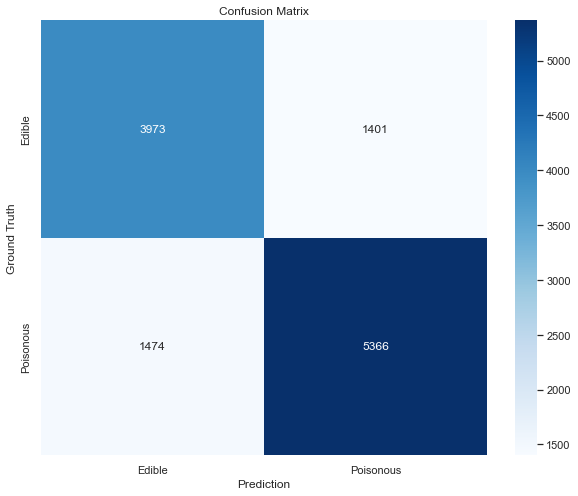

In [21]:
log_par = {'solver': ['liblinear', 'saga'],
           'penalty': ['l1', 'l2'],
           'C': [3, 5, 7],
           'max_iter': [7000, 8000, 9000],
           'random_state': [42]}

logistic_regression, y_pred_lr, lr_metric, lr_parameters = Classifier('logistic regression', log_par, 5, X_train, y_train, X_test, y_test)

Decision Tree

Cross validation score of decision tree: [0.99467813 0.99283594 0.99304063 0.99396172 0.99375704]
Grid search best accuracy score: 0.7997
Grid search best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 12, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__max_leaf_nodes': 80, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__random_state': 42}
Accuracy: 0.8157
Precision: 0.8174
Recall: 0.8639
F1 Score: 0.84


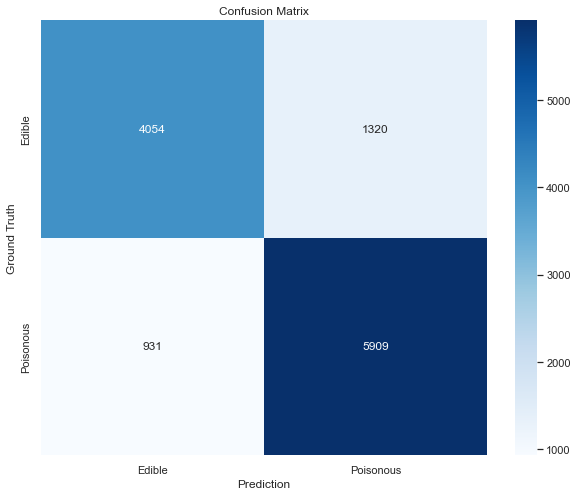

In [22]:
dt_par = {'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth': [4, 6, 10, 12],
          'min_samples_leaf': [2, 4, 6, 8],
          'criterion': ['gini', 'entropy'],
          'max_leaf_nodes': [20, 40, 60, 80],
          'random_state': [42]
         }

decision_tree, y_pred_dt, dt_metric, dt_parameters = Classifier('decision tree', dt_par, 5, X_train, y_train, X_test, y_test)

Multi-layer Perceptron

Cross validation score of mlp: [0.99631563 0.99457579 0.99518985 0.99385938 0.99641797]
Grid search best accuracy score: 0.9954
Grid search best parameters: {'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (78,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__max_iter': 1000, 'mlpclassifier__random_state': 42, 'mlpclassifier__solver': 'adam'}
Accuracy: 0.9964
Precision: 0.9977
Recall: 0.9959
F1 Score: 0.9968


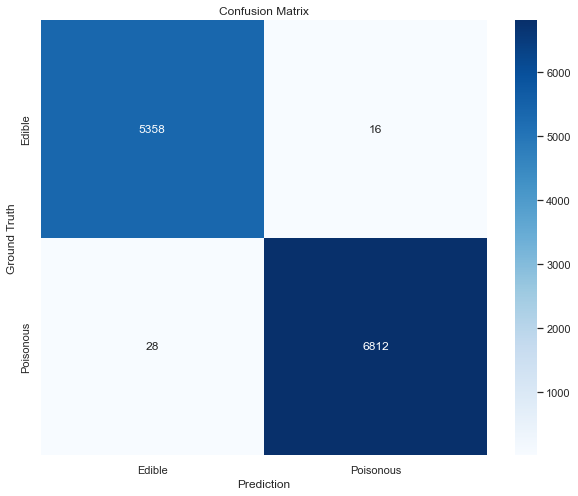

In [23]:
mlp_par = {'solver': ['adam'], 
           'max_iter': [1000, 2000, 3000], 
           'learning_rate': ['constant', 'adaptive'], 
           'alpha': [0.1, 0.01, 0.001], 
           'hidden_layer_sizes': [(78, ), (150, )],
           'random_state': [42]
           }

mlp, y_pred_mlp, mlp_metric, mlp_parameters = Classifier('mlp', mlp_par, 5, X_train, y_train, X_test, y_test)

Random Forest

Cross validation score of random forest: [0.9983625  0.99815781 0.99877188 0.9983625  0.99918125]
Grid search best accuracy score: 0.9831
Grid search best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 42}
Accuracy: 0.9794
Precision: 0.9848
Recall: 0.9784
F1 Score: 0.9816


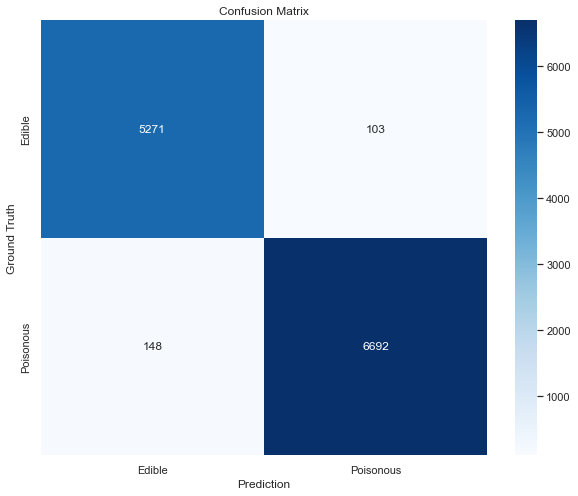

In [24]:
rf_par = {'n_estimators': [50, 100, 200],
          'max_depth': [4, 6, 10, 12],
          'min_samples_split': [2, 4, 6, 8],
          'min_samples_leaf': [1, 2, 3, 4],
          'random_state': [42]
          }

random_forest, y_pred_rf, rf_metric, rf_parameters = Classifier('random forest', rf_par, 5, X_train, y_train, X_test, y_test)

AdaBoost

Cross validation score of ada boost: [0.78303142 0.78282673 0.77985877 0.78333845 0.79510797]
Grid search best accuracy score: 0.8013
Grid search best parameters: {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 200, 'adaboostclassifier__random_state': 42}
Accuracy: 0.7989
Precision: 0.8226
Recall: 0.8171
F1 Score: 0.8199


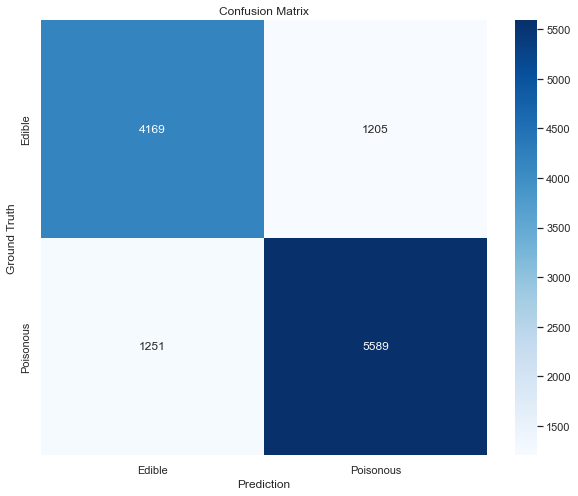

In [25]:
ada_par = {'n_estimators': [50, 100, 200],
           'learning_rate': [0.1, 0.5, 1],
           'random_state': [42]
           }       

ada_boost, y_pred_ada, ada_metric, ada_parameters = Classifier('ada boost', ada_par, 5, X_train, y_train, X_test, y_test)

XGBoost

Cross validation score of xgboost: [0.99611094 0.99559922 0.99570157 0.99631563 0.996725  ]
Grid search best accuracy score: 0.9938
Grid search best parameters: {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__random_state': 42, 'xgbclassifier__subsample': 0.6, 'xgbclassifier__use_label_encoder': False}
Accuracy: 0.9942
Precision: 0.9969
Recall: 0.9927
F1 Score: 0.9948


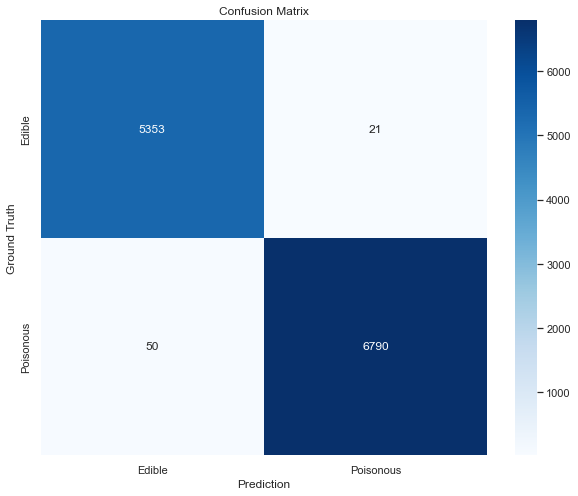

In [26]:
xgb_par = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'random_state': [42],
    'use_label_encoder': [False]
    }

xgboost, y_pred_xgb, xgb_metric, xgb_parameters = Classifier('xgboost', xgb_par, 5, X_train, y_train, X_test, y_test)

LightGBM

Cross validation score of lightgbm: [0.99375704 0.99211954 0.99201719 0.99314297 0.9943711 ]
Grid search best accuracy score: 0.9982
Grid search best parameters: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 12, 'lgbmclassifier__n_estimators': 200, 'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__random_state': 42, 'lgbmclassifier__verbose': -1}
Accuracy: 0.9984
Precision: 0.9994
Recall: 0.9978
F1 Score: 0.9986


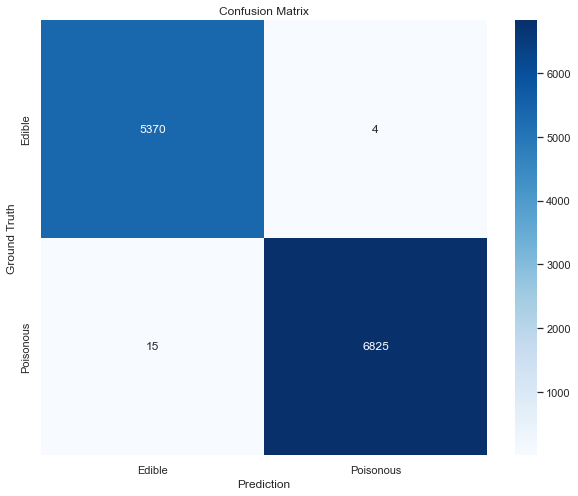

In [27]:
lgbm_par = {
    'num_leaves': [31, 40, 50],
    'max_depth': [4, 6, 10, 12],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'random_state': [42],
    'verbose': [-1]
    }

lightgbm, y_pred_lgbm, lgbm_metric, lgbm_parameters = Classifier('lightgbm', lgbm_par, 5, X_train, y_train, X_test, y_test)

# Explanation

Retrain the ML model

In [21]:
hyperparameters_path = "E:/PhD Thesis/Trust/Results/Models/2024-04-23/Best Parameters [ada boost].csv"
hyperparameters = pd.read_csv(hyperparameters_path)

# Drop redundant characters from hyperparameter dataframe columns using split() function
# NOTE: Based on the implemented ML model, you need to change the string in the split() function
hyperparameters.columns = [x.split('adaboostclassifier__')[1] for x in hyperparameters.columns]

# Conver the hyperparameters dataframe to a dictionary
hyperparameters_dict = hyperparameters.to_dict(orient='records')[0]

In [22]:
hyperparameters_dict

{'learning_rate': 1, 'n_estimators': 200, 'random_state': 42}

In [23]:
model = AdaBoostClassifier(learning_rate=hyperparameters_dict['learning_rate'], n_estimators=hyperparameters_dict['n_estimators'], random_state=hyperparameters_dict['random_state']).fit(X_train, y_train)

probability = model.predict_proba(X_test)
prediction = model.predict(X_test)

ML model statistical analysis for classification on test dataset

In [24]:
# Print percentage of correctly classified Poisonous class
correct_poisonous = len(y_test[(y_test == 1) & (y_test == prediction)]) / len(y_test[y_test == 1]) * 100
print(f"Correctly classified Poisonous class: {correct_poisonous:.2f}%")

# Print percentage of correctly classified Edible class
correct_edible = len(y_test[(y_test == 0) & (y_test == prediction)]) / len(y_test[y_test == 0]) * 100
print(f"Correctly classified Edible class: {correct_edible:.2f}%")

Correctly classified Poisonous class: 81.71%
Correctly classified Edible class: 77.58%


In [25]:
# Print number of correctly classified Poisonous class
correct_poisonous = len(y_test[(y_test == 1) & (y_test == prediction)])
print(f"Number of correctly classified Poisonous class: {correct_poisonous}")

# Print number of correctly classified Edible class
correct_edible = len(y_test[(y_test == 0) & (y_test == prediction)])
print(f"Number of correctly classified Edible class: {correct_edible}")

Number of correctly classified Poisonous class: 5589
Number of correctly classified Edible class: 4169


In [26]:
# Function of misclassified samples
def misclassified_samples(y_test, prediction):
    # Define the mapping dictionary
    label_map = {1: "Poisonous", 0: "Edible"}

    # Get the misclassified samples
    misclassified = y_test.index[prediction != y_test]
    # Get the index of the misclassified samples
    misclassified_index = y_test.index.get_indexer(misclassified)

    for i in misclassified_index:
        # Replace the numeric values with labels
        true_class = label_map[y_test.iloc[i]]
        predicted_class = label_map[prediction[i]]
        print(f"Index in y_test: {y_test.index[i]}, Order in y_test: {i}, Ground truth class: {true_class}, Predicted class: {predicted_class}")

    return misclassified, misclassified_index

misclassified, misclassified_index = misclassified_samples(y_test, prediction)

Index in y_test: 33350, Order in y_test: 7, Ground truth class: Poisonous, Predicted class: Edible
Index in y_test: 431, Order in y_test: 8, Ground truth class: Poisonous, Predicted class: Edible
Index in y_test: 51715, Order in y_test: 12, Ground truth class: Edible, Predicted class: Poisonous
Index in y_test: 38606, Order in y_test: 13, Ground truth class: Poisonous, Predicted class: Edible
Index in y_test: 51637, Order in y_test: 21, Ground truth class: Edible, Predicted class: Poisonous
Index in y_test: 16716, Order in y_test: 23, Ground truth class: Edible, Predicted class: Poisonous
Index in y_test: 484, Order in y_test: 35, Ground truth class: Poisonous, Predicted class: Edible
Index in y_test: 12678, Order in y_test: 40, Ground truth class: Edible, Predicted class: Poisonous
Index in y_test: 16912, Order in y_test: 41, Ground truth class: Edible, Predicted class: Poisonous
Index in y_test: 30718, Order in y_test: 42, Ground truth class: Poisonous, Predicted class: Edible
Index 

SHAP implementation

In [27]:
# SHAP Explainer
# explainer = shap.Explainer(model, X_train, feature_names=X_train.columns)
# shap_values = explainer(X_test)

# Kernel Explainer
# explainer = shap.KernelExplainer(model.predict_proba, X_train, feature_names=X_train.columns)
# shap_values = explainer.shap_values(X_test, nsamples=1000)

# Tree Explainer
explainer = shap.TreeExplainer(model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

 96%|=================== | 23471/24428 [00:26<00:01]       

In [28]:
new_shap_values = []
for i in range(len(shap_values)):
    instance = []  # Reset
    for j in range(len(shap_values.values[i])):
        instance.append(shap_values.values[i][j][1])
    new_shap_values.append(instance)

In [29]:
# Function to calculate aggregate feature importance for all members of X_test
def aggregate_shapley_values(shap_values, X_test, column_list):
    # exctract number of uniques values for each feature
    nunique = X[column_list].nunique()

    # If features are numerical assign nuique=1 otherwise pass
    for i in numeric_features:
        for j in nunique.index:
            if j == i:
                nunique[i] = 1
            else:
                pass

    step = np.insert(nunique, 0, 0).tolist()

    initial_value = 0
    final = []

    for i in range(0, len(step)):
        initial_value += step[i]
        final.append(initial_value)

    # Feature importance for all X_test
    X_test_feature_importance = {}
    for z in range(0, len(X_test)):
        feature_importance = {}
        for i in column_list:
            # If you use any explanation rather than TreeExplainer, use the following line
            # feature_importance[i] = sum(shap_values.values[z][final[column_list.index(i)]:final[column_list.index(i)+1]])
            # Otherwise, use the following line
            feature_importance[i] = sum(shap_values[z][final[column_list.index(i)]:final[column_list.index(i)+1]])
        X_test_feature_importance[z] = feature_importance

    X_test_feature_importance = pd.DataFrame(X_test_feature_importance).T
    X_test_feature_importance.index = X_test.index

    return X_test_feature_importance

In [30]:
X_test_feature_importance = aggregate_shapley_values(new_shap_values, X_test, column_list)

Explanation functions

In [33]:
# Function to plot feature importance
def plot_feature_importance(sample, X_test_feature_importance, probability, path):
    
    colors = ['#03A9F4' if x < 0 else '#E91E63' for x in X_test_feature_importance.iloc[sample, :].values]
    
    # Create a dictionary to map feature names to their corresponding values
    X_test_index = X_test.index[sample]
    feature_dict = {}
    for i in column_list:
        feature_dict[i] = df_names.iloc[X_test_index][i]

    plt.figure(figsize=(15, 10))
    plt.barh(X_test_feature_importance.columns, X_test_feature_importance.iloc[sample, :].values, color=colors)
    plt.title(f'Feature Importance for Mushroom #{X_test_feature_importance.index[sample]}', fontsize=18, fontweight='bold')
    plt.xlabel('SHAP value (impact on model output)', fontsize=16, fontweight='bold')
    plt.ylabel('Feature', fontsize=16, fontweight='bold')
    
    # Assign feature_dict to y-axis labels
    plt.xticks(fontsize=16)
    plt.yticks(ticks=range(len(X_test_feature_importance.columns)), labels=[f'{key}={value}' for key, value in feature_dict.items()], fontsize=15, fontweight='bold')
    
    # Create legend patches
    patch1 = mpatches.Patch(color='#03A9F4', label=f'Edible: {round(probability[sample][0], 4)}')
    patch2 = mpatches.Patch(color='#E91E63', label=f'Poisinous: {round(probability[sample][1], 4)}')
    
    # Add legend with increased fontsize
    plt.legend(handles=[patch1, patch2], fontsize='large')
    plt.savefig(path + f'/Feature Importance [{sample}].png', dpi=800, bbox_inches='tight', facecolor='w', format='png')
    plt.show()

# Data modification class
class ValueReplacement:
    def __init__(self, data, column, replaced_column=None, attribute_mappings=None):
        self.data = data
        self.column = column
        self.replaced_column = replaced_column
        self.attribute_mappings = attribute_mappings
        self.numeric_features = ['cap-diameter', 'stem-height', 'stem-width']
        self.categorical_features = data.drop(columns=self.numeric_features).columns
        
    def dummy_show(self):
        X = self.data.copy()
        for i in range(len(X.columns)):
            if self.column in X.columns[i]:
                if X.iloc[0, i] == 1:
                    dummy = X.columns[i]
                    if dummy == self.replaced_column:
                        # If the dummy column is the same as the replaced column, find the next dummy column
                        dummy = X.columns[i+1]
                        print(f'The original value of feature is in column {dummy}')
                    else:
                        print(f'The original value of feature is in column {dummy}')
                    return dummy
        raise ValueError(f"No dummy column found for {self.column}")

    def dummy_replace(self, dummy):
        if self.replaced_column is None:
            raise ValueError("replaced_column must be set for dummy_replace operation")
        X = self.data.copy()
        X[dummy].replace(1, 0, inplace=True)
        X[self.replaced_column].replace(0, 1, inplace=True)
        print(f'The value of {self.replaced_column} has been changed to 1, and the value of {dummy} has been changed to 0')
        order = int(self.replaced_column[-1])
        value_name = list(attribute_mappings[self.column].values())[order][0]
        return X, value_name

    def replace_numeric_value(self, selected_data, main_data, desired_value):
        if self.column not in self.numeric_features:
            raise ValueError(f"Column '{self.column}' is not a numeric feature")
        if desired_value > 62.34:
            raise ValueError('The value is higher than the maximum value of the dataset')
        elif desired_value < 0.38:
            raise ValueError('The value is lower than the minimum value of the dataset')
        else:
            data_selected = selected_data.copy()
            data_main = main_data.copy()
            idx = data_selected.index[0]
            original_value = main_data[self.column][idx]
            normalized_value = selected_data[self.column][idx]
            data_main[self.column].replace(original_value, desired_value, inplace=True)
            scaler = MinMaxScaler()
            data_main = pd.DataFrame(scaler.fit_transform(data_main), columns=data_main.columns)
            new_value = data_main[self.column][idx]
            data_selected[self.column].replace(normalized_value, new_value, inplace=True)
            return data_selected

    def is_categorical_based_on_characters(self):
        for cat_col in self.categorical_features:
            match_count = sum(1 for a, b in zip(self.column, cat_col) if a == b)
            if match_count >= 7:
                return True
        return False

    def process_column(self, selected_data, main_data, desired_value=None):
        if self.is_categorical_based_on_characters():
            dummy = self.dummy_show()
            return self.dummy_replace(dummy)
        elif self.column in self.numeric_features:
            if desired_value is None:
                raise ValueError(f"Desired value must be provided for numeric feature '{self.column}'")
            return self.replace_numeric_value(selected_data, main_data, desired_value)
        else:
            raise ValueError(f"The column '{self.column}' type is not supported")

# Function to retun new probability and prediction
def new_prediction_probability(model, new_data):
    new_probability = model.predict_proba(new_data)[0]
    print(f'The new probability is: {new_probability}')
    new_prediction = model.predict(new_data)[0]
    print(f'The new prediction is: {new_prediction}')
    return new_probability, new_prediction

# Function to new data with SHAP
def new_shapley_values(new_data):
    instance_shap_values = explainer(new_data)

    new_shap = []
    for i in range(len(instance_shap_values)):
        instance = []  # Reset
        for j in range(len(instance_shap_values.values[i])):
            instance.append(instance_shap_values.values[i][j][1])
        new_shap.append(instance)

    return new_shap

# Function to plot new feature importance
def plot_new_feature_importance(new_data, new_feature_importance, new_probability, modified_feature, new_value, path):
    
    colors = ['#03A9F4' if x < 0 else '#E91E63' for x in new_feature_importance.iloc[0, :].values]

    X_test_index = new_data.index[0]
    positional_index = X_test.index.get_loc(X_test_index)
    feature_dict = {}
    for i in column_list:
        feature_dict[i] = df_names.iloc[X_test_index][i]

    feature_dict[modified_feature] = new_value

    plt.figure(figsize=(15, 10))
    plt.barh(new_feature_importance.columns, new_feature_importance.iloc[0, :].values, color=colors)
    plt.title(f'Feature Importance for Mushroom #{new_feature_importance.index[0]}', fontsize=17, fontweight='bold')
    plt.xlabel('SHAP value (impact on model output)', fontsize=15, fontweight='bold')
    plt.ylabel('Feature', fontsize=15, fontweight='bold')

    # Assign feature_dict to y-axis labels
    plt.xticks(fontsize=14)
    plt.yticks(ticks=range(len(new_feature_importance.columns)), labels=[f'{key}={value}' for key, value in feature_dict.items()], fontsize=14)

    # Create legend patches
    patch1 = mpatches.Patch(color='#03A9F4', label=f'Edible: {round(new_probability[0], 4)}')
    patch2 = mpatches.Patch(color='#E91E63', label=f'Poisinous: {round(new_probability[1], 4)}')

    # Add legend with increased fontsize
    plt.legend(handles=[patch1, patch2], fontsize='large')
    plt.savefig(path + f'/Feature Importance [{positional_index}][{modified_feature}={new_value}].png', dpi=800, bbox_inches='tight', facecolor='w')
    plt.show()

    return

# Function change the value of a categorical feature
def create_new_categorical_instance(selected_data, my_selected_features):
    
    # Create a random integer in [0, 5]
    random_integer = random.randint(0, 5)

    # Create an instance of the class
    value_replacement = ValueReplacement(selected_data, my_selected_features, my_selected_features + '_' + str(random_integer))

    # Call the combined method
    new_data, new_value = value_replacement.process_column(selected_data, X, attribute_mappings)

    # Retrain the model
    new_probability, new_prediction = new_prediction_probability(model, new_data)

    # Calculate SHAP
    new_shap = new_shapley_values(new_data)

    # Aggregate the SHAP values
    new_feature_importance = aggregate_shapley_values(new_shap, new_data, column_list)

    # Plot Feature Importance
    plot_new_feature_importance(new_data, new_feature_importance, new_probability, my_selected_features, new_value, main_path)


# Function to change the value of a numerical feature
def create_new_numeric_feature(selected_data, column):

    # Find the original value of the column
    data = selected_data[0:1].copy()
    selected_data_index = data.index[0]
    print(f'The original value of {column} is: {X[column][selected_data_index]}')

    # Create an instance of the class
    value_replacement = ValueReplacement(selected_data, column)

    # Call the combined method
    new_value = round(random.uniform(0.38, 33.92), 2)
    new_data = value_replacement.process_column(selected_data, X, new_value)
    print(f'The new value of {column} is: {new_value}')

    # Retrain the model
    new_probability, new_prediction = new_prediction_probability(model, new_data)

    # Calculate SHAP
    new_shap = new_shapley_values(new_data)

    # Aggregate the SHAP values
    new_feature_importance = aggregate_shapley_values(new_shap, new_data, column_list)

    # Plot Feature Importance
    plot_new_feature_importance(new_data, new_feature_importance, new_probability, column, new_value, main_path)

SHAP feature importance plot for the main instance

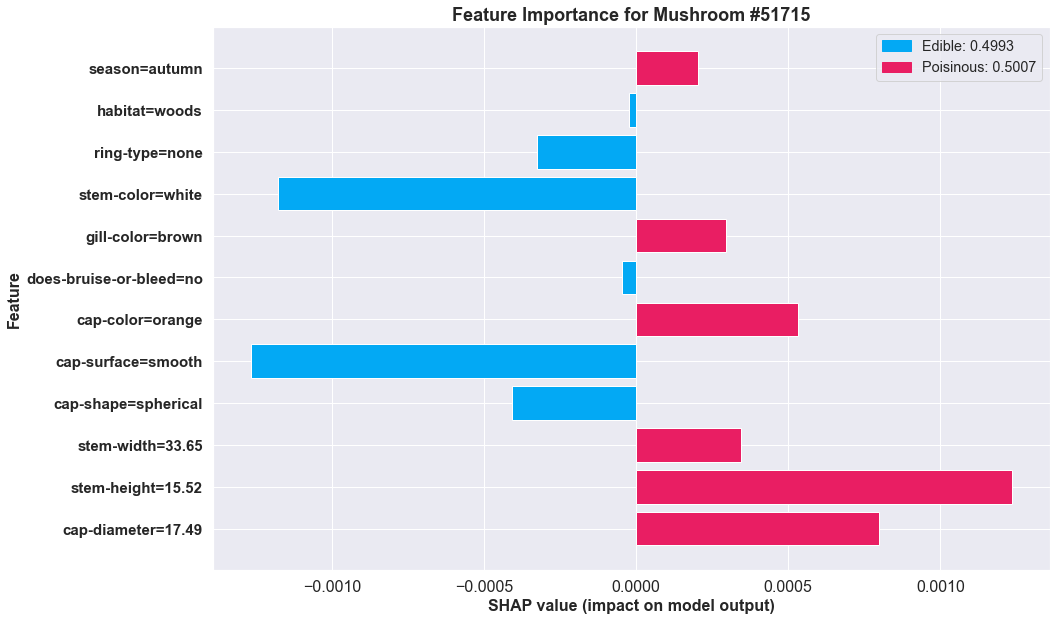

,cap-diameter,stem-height,stem-width,cap-shape_0,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,cap-shape_6,...,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6,habitat_7,season_0,season_1,season_2,season_3
51715,0.276146,0.457547,0.323838,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [34]:
# Create a copy of instance that is not changeable in the main dataframe

instance = 12
plot_feature_importance(instance, X_test_feature_importance, probability, main_path)

selected_data = X_test[instance:instance+1].copy()
selected_data

Change categorical features value

The original value of feature is in column cap-shape_5
The value of cap-shape_4 has been changed to 1, and the value of cap-shape_5 has been changed to 0
The new probability is: [0.49923264 0.50076736]
The new prediction is: 1


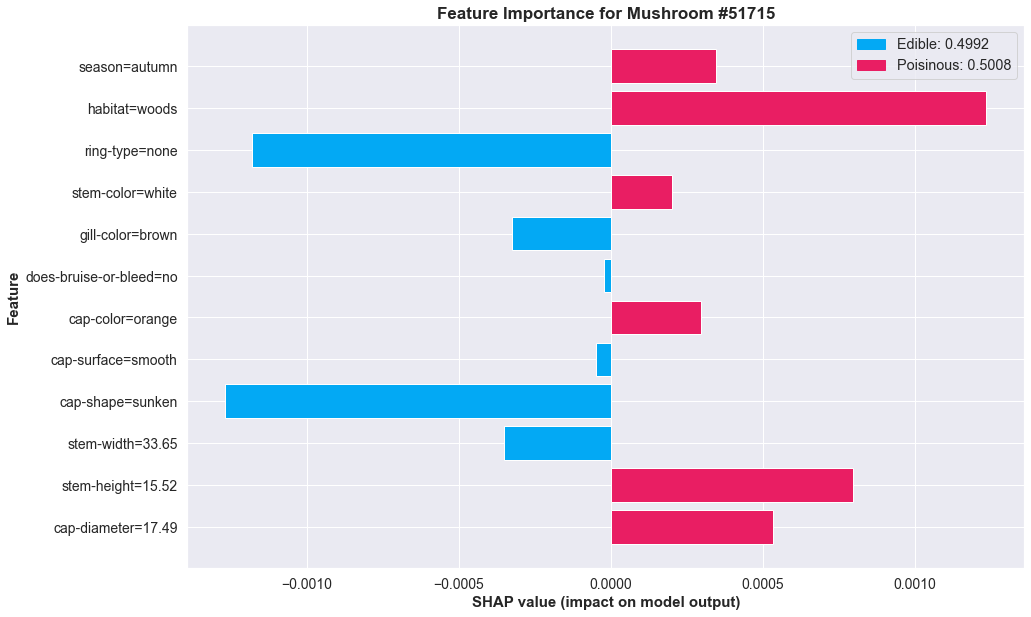

The original value of feature is in column cap-surface_4
The value of cap-surface_3 has been changed to 1, and the value of cap-surface_4 has been changed to 0
The new probability is: [0.49929216 0.50070784]
The new prediction is: 1


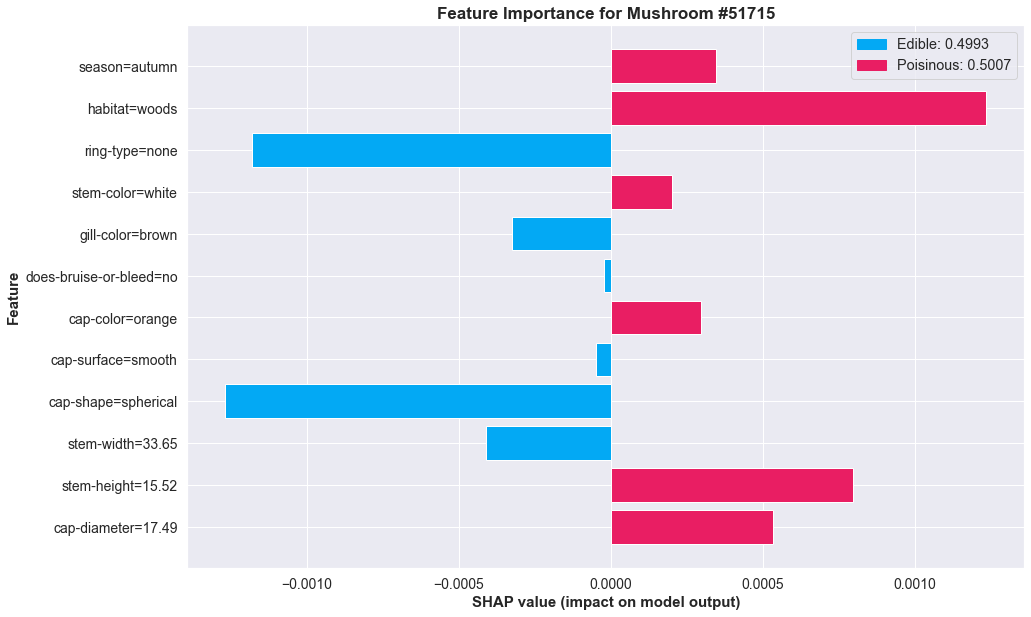

The original value of feature is in column cap-color_10
The value of cap-color_5 has been changed to 1, and the value of cap-color_10 has been changed to 0
The new probability is: [0.49900901 0.50099099]
The new prediction is: 1


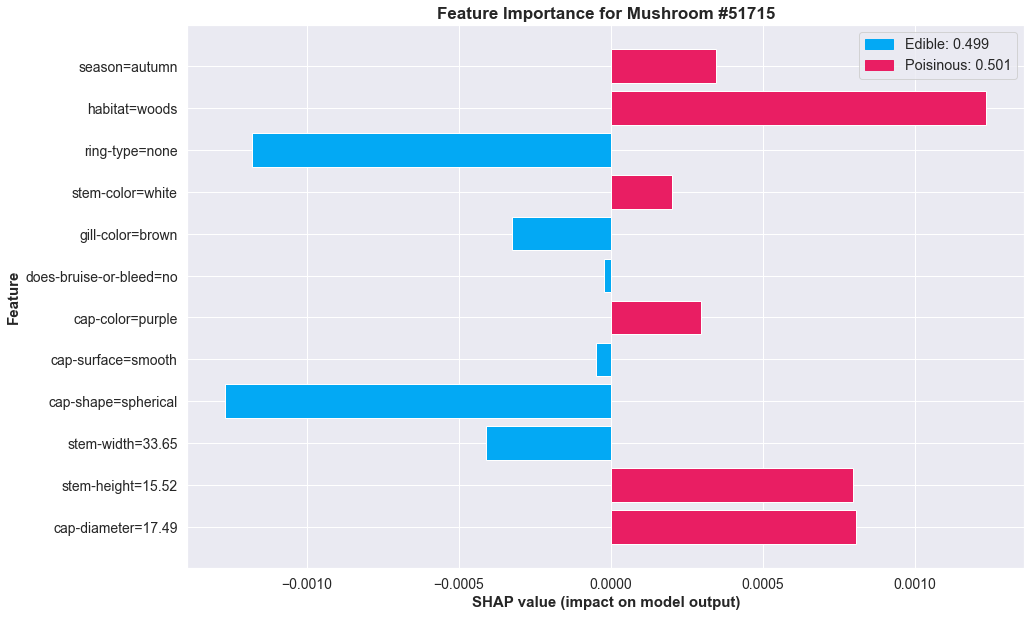

The original value of feature is in column gill-color_0
The value of gill-color_5 has been changed to 1, and the value of gill-color_0 has been changed to 0
The new probability is: [0.49870265 0.50129735]
The new prediction is: 1


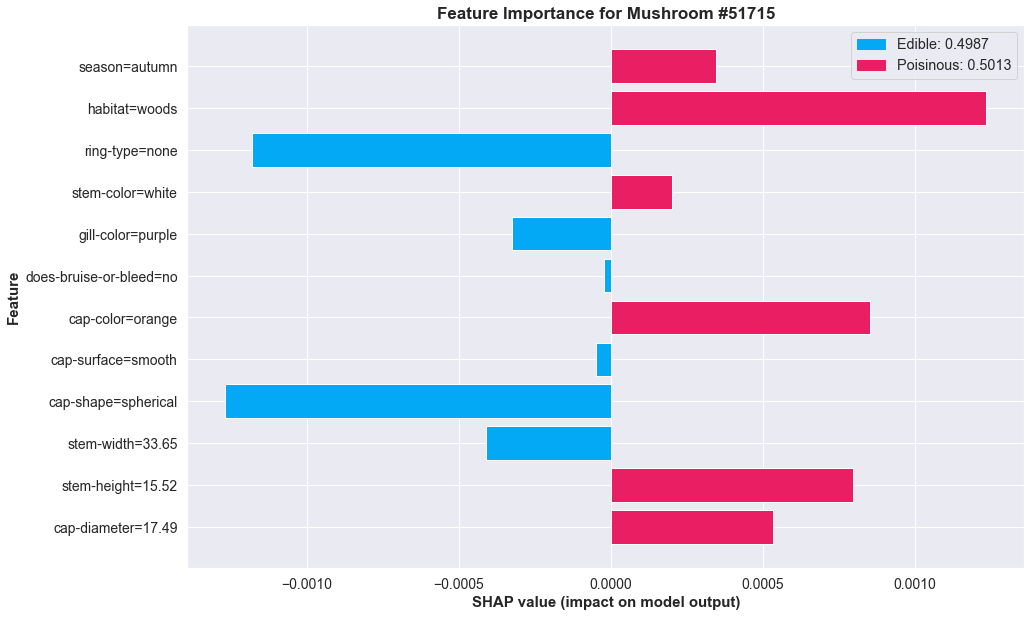

The original value of feature is in column stem-color_7
The value of stem-color_5 has been changed to 1, and the value of stem-color_7 has been changed to 0
The new probability is: [0.49633996 0.50366004]
The new prediction is: 1


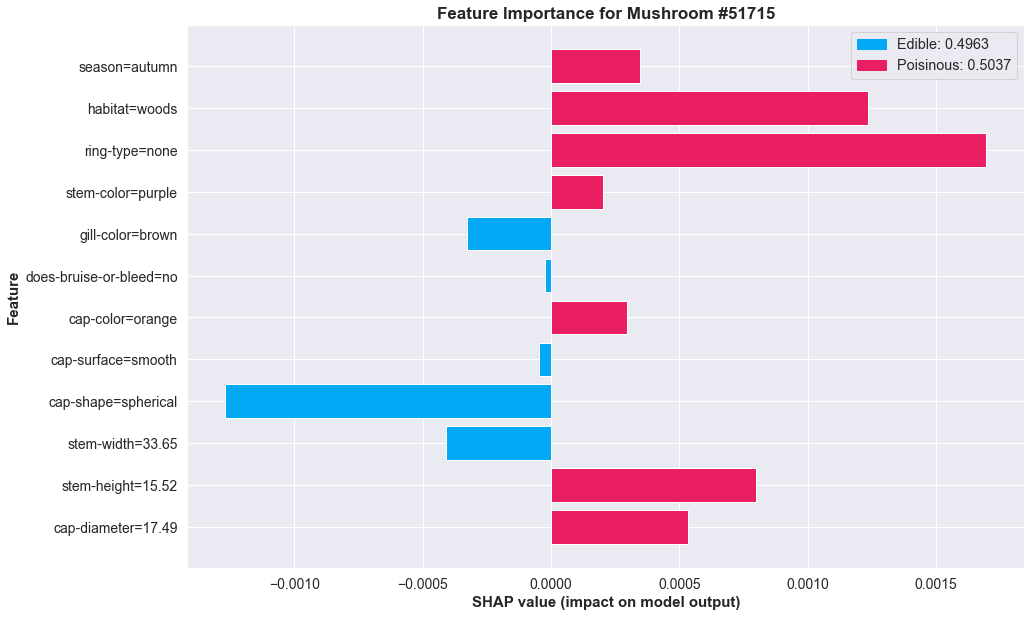

The original value of feature is in column ring-type_10
The value of ring-type_5 has been changed to 1, and the value of ring-type_10 has been changed to 0
The new probability is: [0.49791092 0.50208908]
The new prediction is: 1


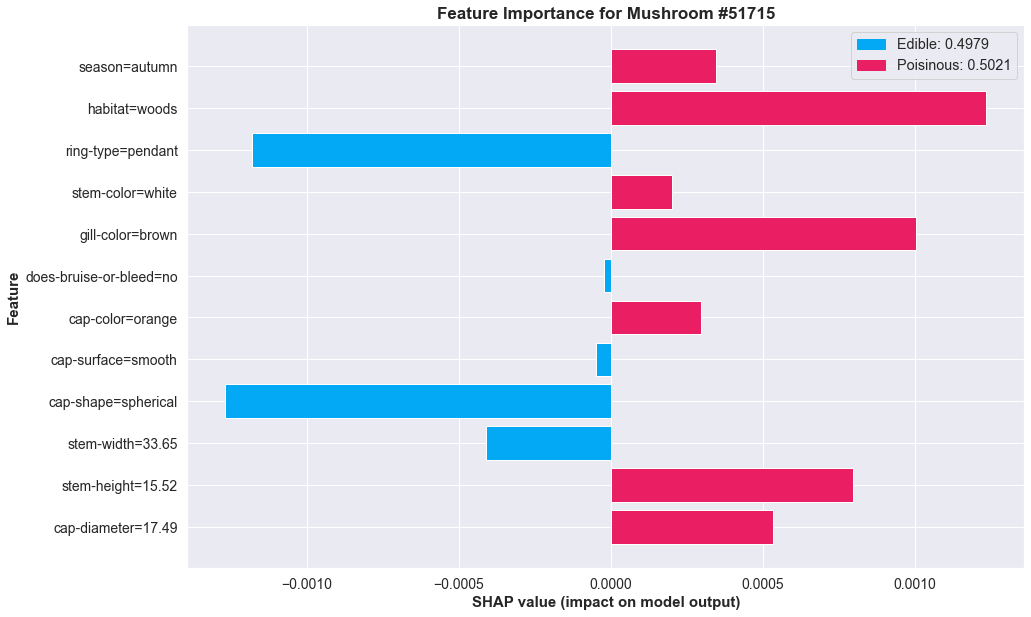

The original value of feature is in column habitat_7
The value of habitat_3 has been changed to 1, and the value of habitat_7 has been changed to 0
The new probability is: [0.45435099 0.54564901]
The new prediction is: 1


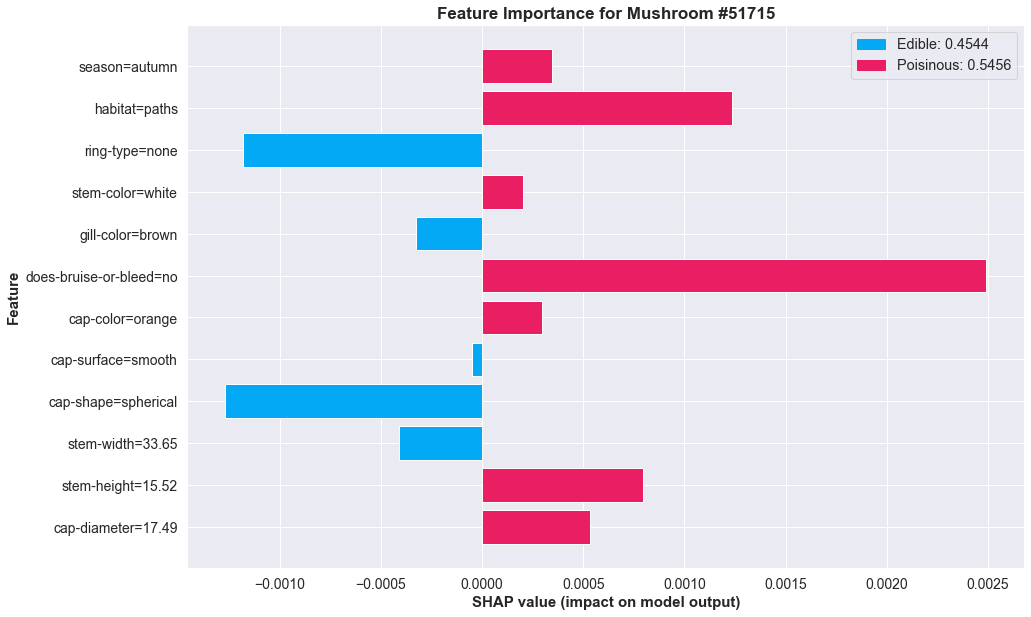

In [35]:
edit_categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'gill-color', 'stem-color', 'ring-type', 'habitat']

for i in edit_categorical_features:
    create_new_categorical_instance(selected_data, i)

Change numeric features value

The original value of cap-diameter is: 17.49
The new value of cap-diameter is: 5.48
The new probability is: [0.50072999 0.49927001]
The new prediction is: 0


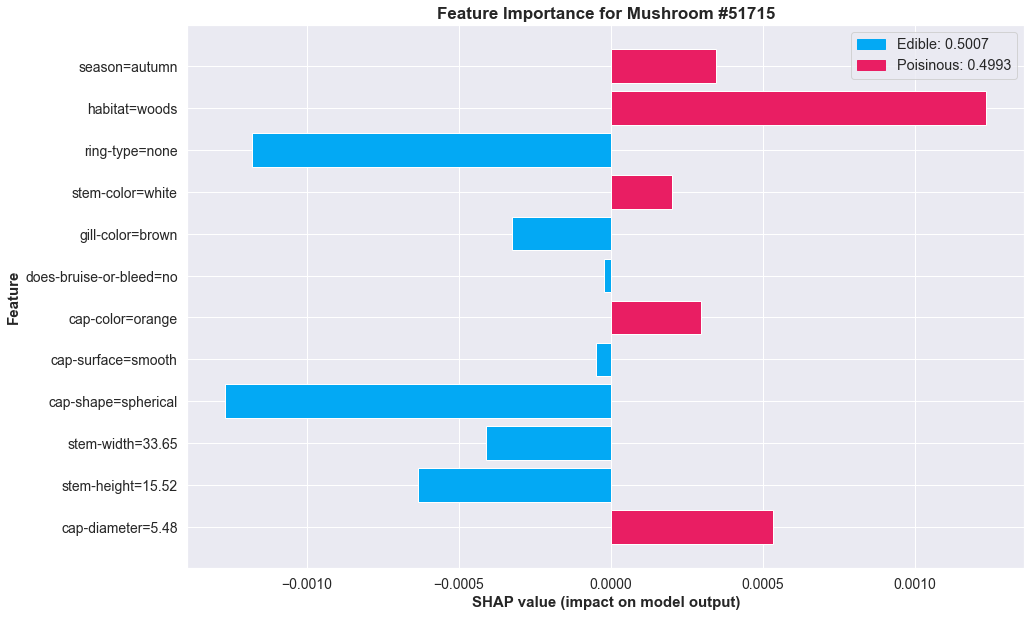

The original value of stem-height is: 15.52
The new value of stem-height is: 12.95
The new probability is: [0.49929216 0.50070784]
The new prediction is: 1


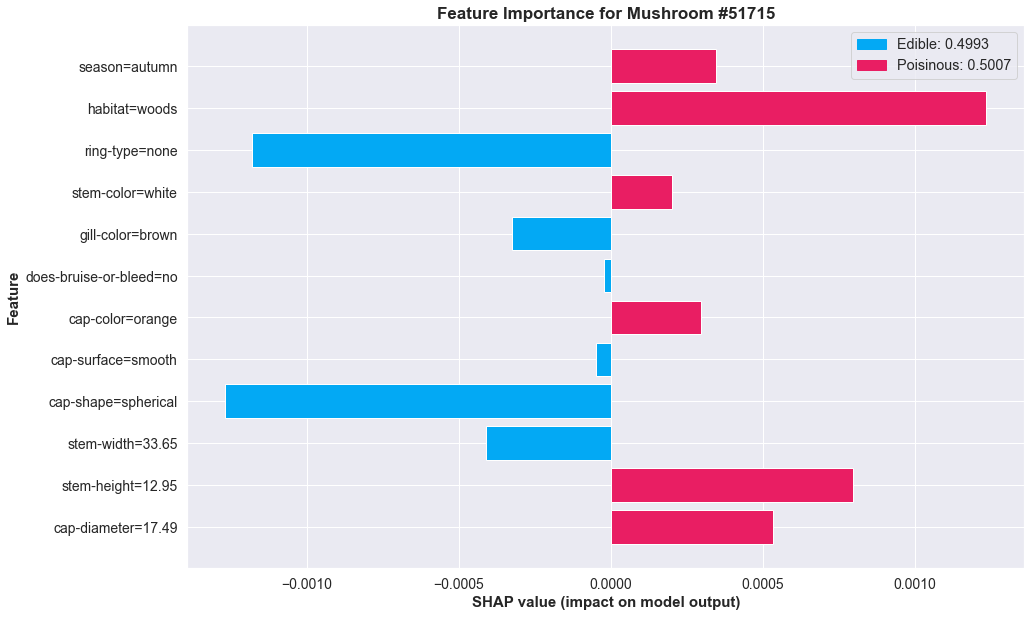

The original value of stem-width is: 33.65
The new value of stem-width is: 2.57
The new probability is: [0.49793286 0.50206714]
The new prediction is: 1


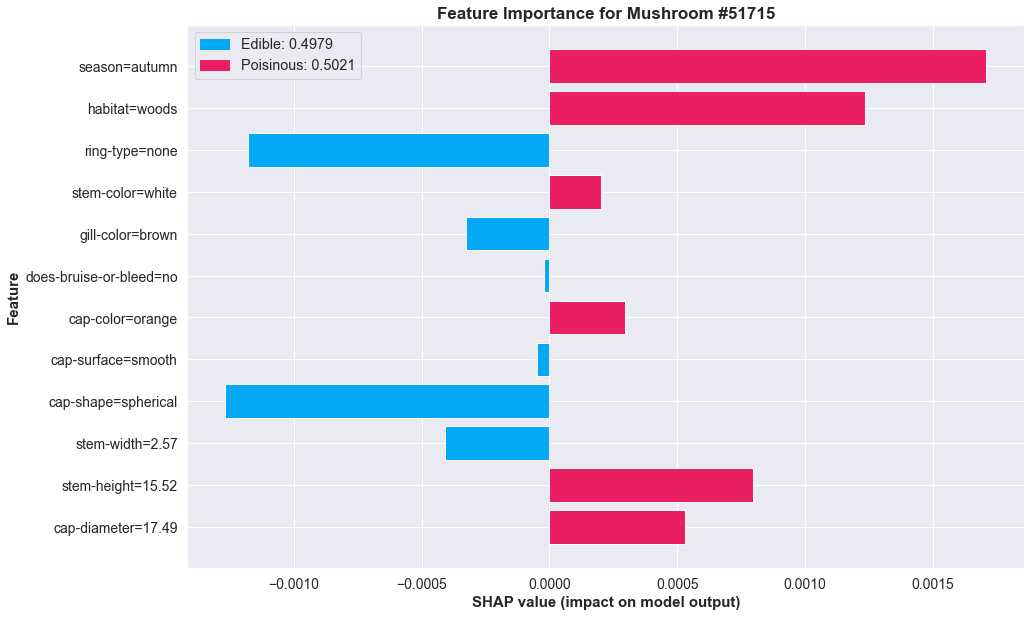

In [36]:
edit_numeric_features = ['cap-diameter', 'stem-height', 'stem-width']

for i in edit_numeric_features:
    create_new_numeric_feature(selected_data, i)

Selecting similar instances to main instance based on Euclidean distance

In [37]:
instance = 212

# Check whether an index is there in X_test
inx_list = X_test.index[instance]
# Find the index
if inx_list in X_test.index:
    print("Yes")
    # Retun location
    print(f'The instance index is: {inx_list}')
else:
    print('No')

Yes
The instance index is: 26676


In [38]:
# Calculate Ecleadian distance with all samples and find 10 most closest ones
def euclidean_distance(X_test, sample, y_test, prediction, ground_truth=True, y=True):
    dist = []
    for i in range(len(X_test)):
        dist.append(np.linalg.norm(X_test.iloc[sample, :] - X_test.iloc[i, :]))

    # Create a DataFrame directly with all necessary columns
    dist_df = pd.DataFrame({
        'Index': range(len(X_test)),
        'Distance': dist,
        'Class': y_test,
        'Prediction': prediction,
        'Edible Probability': probability[:, 0],
        'Poisonous Probability': probability[:, 1]
    })

    # Print the highest and lowest distance
    min_distance = dist_df['Distance'].min()
    max_distance = dist_df['Distance'].max()
    divide_distance = (max_distance - min_distance) / 5

    # Collect 5 instances from each range
    range1 = dist_df[(dist_df['Distance'] >= min_distance) & (dist_df['Distance'] < min_distance + divide_distance)]
    range2 = dist_df[(dist_df['Distance'] >= min_distance + divide_distance) & (dist_df['Distance'] < min_distance + 2 * divide_distance)]
    range3 = dist_df[(dist_df['Distance'] >= min_distance + 2 * divide_distance) & (dist_df['Distance'] < min_distance + 3 * divide_distance)]

    # Check the ground truth, and select the instances with the same class
    if ground_truth == True and y == True:
        range1 = range1[(range1['Class'] >= 1) & (range1['Prediction'] >= 1)]
        range2 = range2[(range2['Class'] >= 1) & (range2['Prediction'] >= 1)]
        range3 = range3[(range3['Class'] >= 1) & (range3['Prediction'] >= 1)]
    elif ground_truth == True and y == False:
        range1 = range1[(range1['Class'] >= 1) & (range1['Prediction'] < 1)]
        range2 = range2[(range2['Class'] >= 1) & (range2['Prediction'] < 1)]
        range3 = range3[(range3['Class'] >= 1) & (range3['Prediction'] < 1)]
    elif ground_truth == False and y == True:
        range1 = range1[(range1['Class'] < 1) & (range1['Prediction'] >= 1)]
        range2 = range2[(range2['Class'] < 1) & (range2['Prediction'] >= 1)]
        range3 = range3[(range3['Class'] < 1) & (range3['Prediction'] >= 1)]
    elif ground_truth == False and y == False:
        range1 = range1[(range1['Class'] < 1) & (range1['Prediction'] < 1)]
        range2 = range2[(range2['Class'] < 1) & (range2['Prediction'] < 1)]
        range3 = range3[(range3['Class'] < 1) & (range3['Prediction'] < 1)]

    # Randomly collect 5 instances from each range
    if len(range1) < 5:
        range1 = range1.sample(len(range1), replace=True)
    else:
        range1 = range1.sample(5)

    if len(range2) < 5:
        range2 = range2.sample(len(range2), replace=True)
    else:
        range2 = range2.sample(5)

    if len(range3) < 5:
        range3 = range3.sample(len(range3), replace=True)
    else:
        range3 = range3.sample(5)

    # Concatenate all the ranges
    dist_df = pd.concat([range1, range2, range3])

    # Sort the DataFrame by distance
    dist_df = dist_df.sort_values(by='Distance', ascending=True)

    return dist_df, dist_df['Index'].tolist()

distances, collected_indices = euclidean_distance(X_test, instance, y_test, prediction, ground_truth=True, y=False)

distances

,Index,Distance,Class,Prediction,Edible Probability,Poisonous Probability
26676,212,0.000000,1,0,0.500797,0.499203
26692,9617,0.017679,1,0,0.501066,0.498934
26492,6099,0.022330,1,0,0.501066,0.498934
26635,7602,0.025702,1,0,0.500590,0.499410
26701,10008,0.027105,1,0,0.500489,0.499511
26573,10711,1.414288,1,0,0.500797,0.499203
26704,1922,1.414292,1,0,0.500775,0.499225
26753,7356,1.414332,1,0,0.500915,0.499085
26725,5720,1.414358,1,0,0.500684,0.499316
26722,10663,1.414541,1,0,0.500674,0.499326


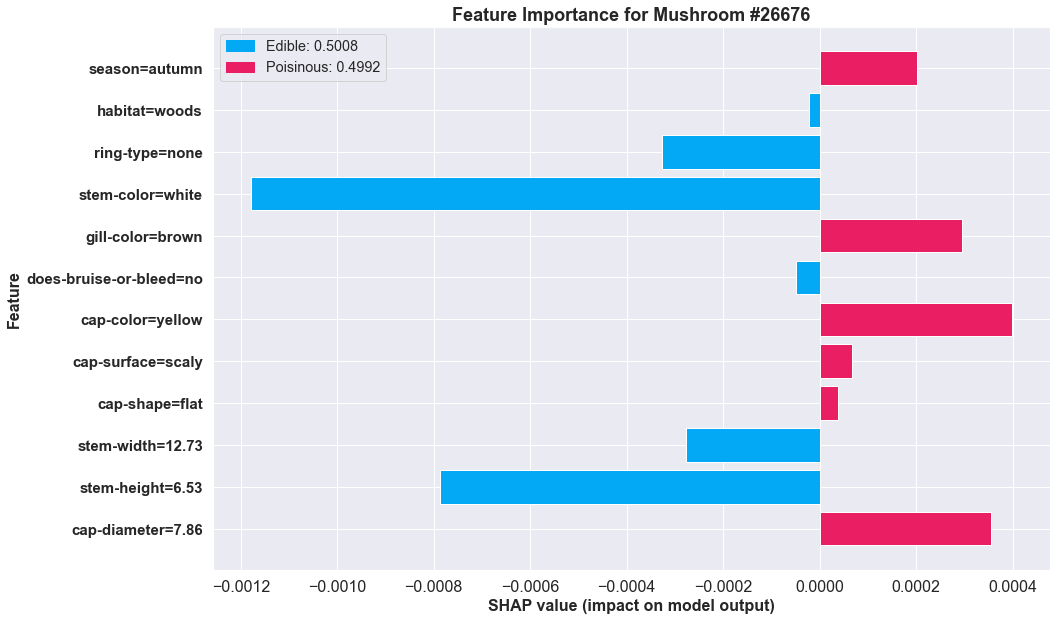

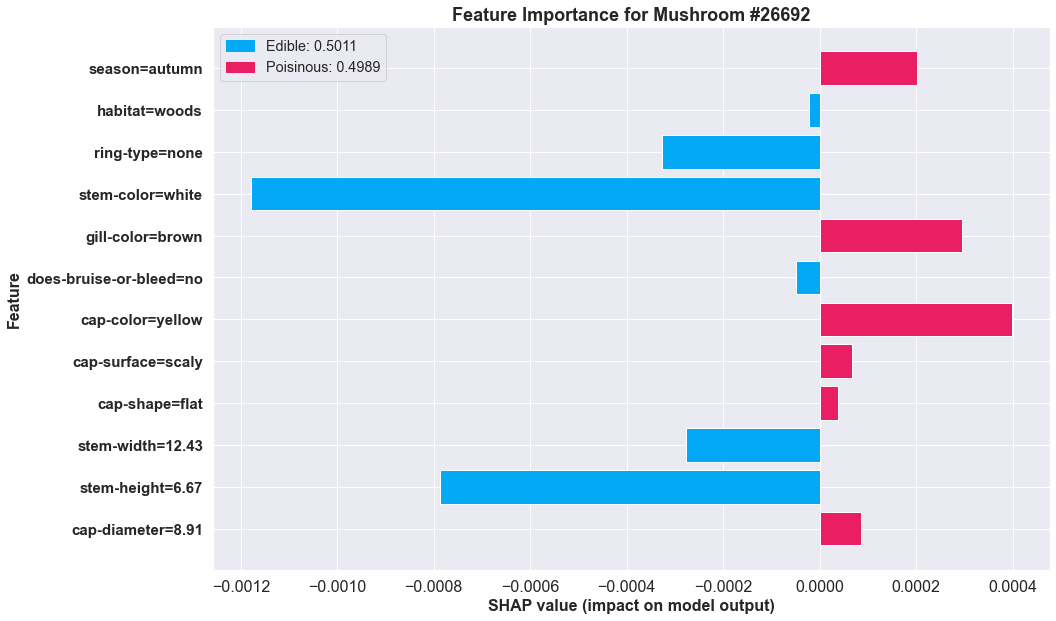

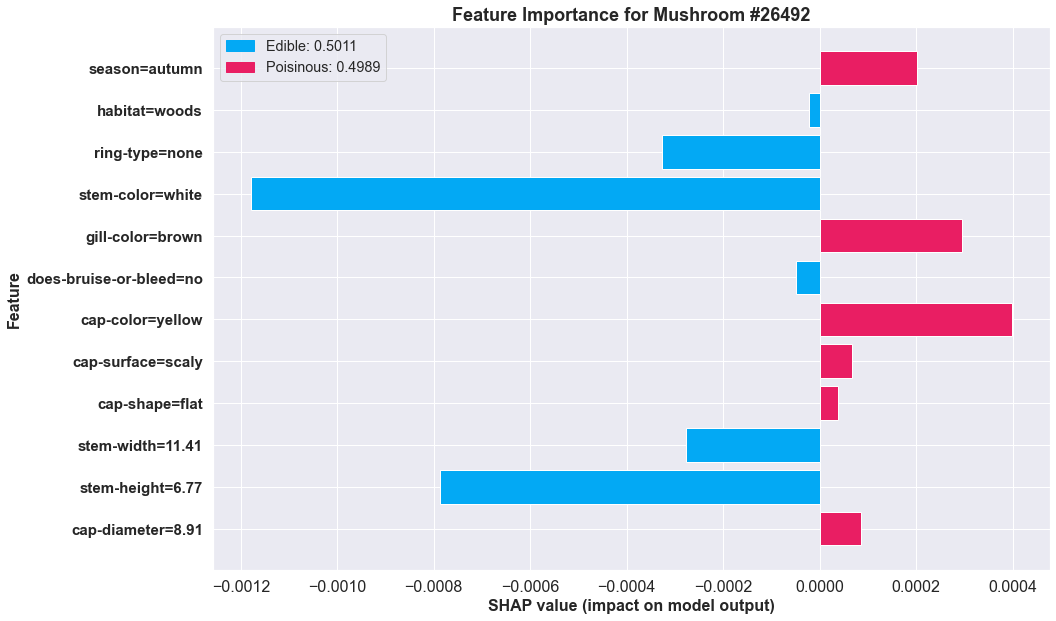

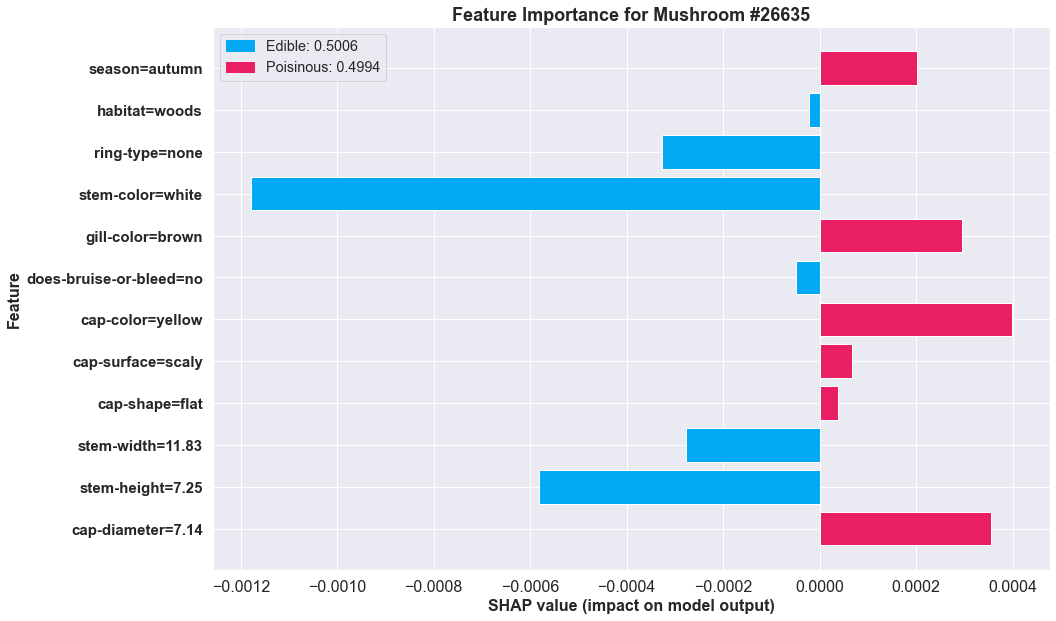

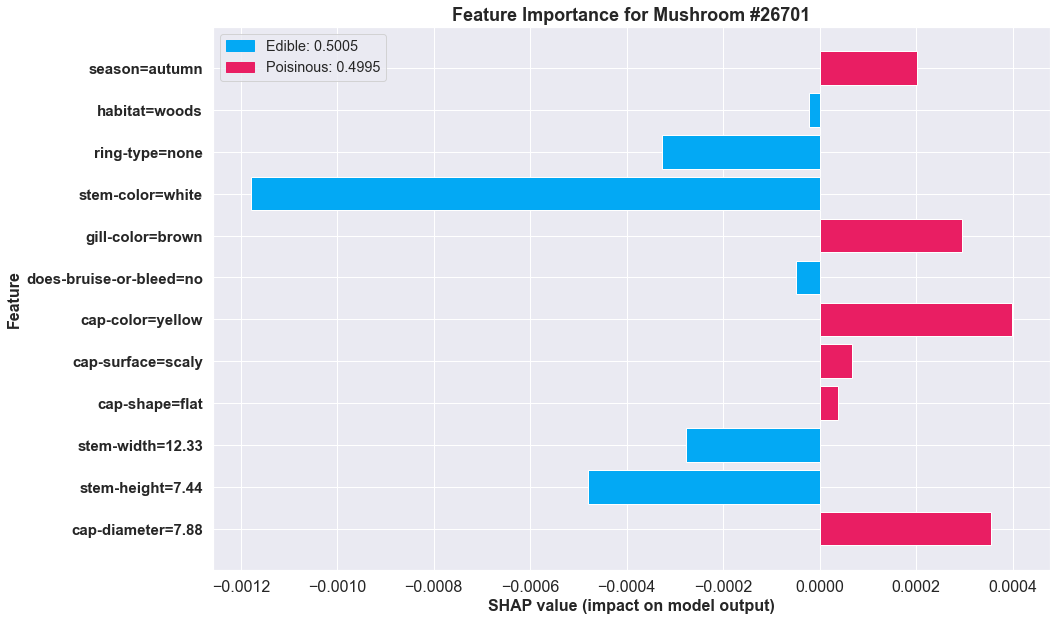

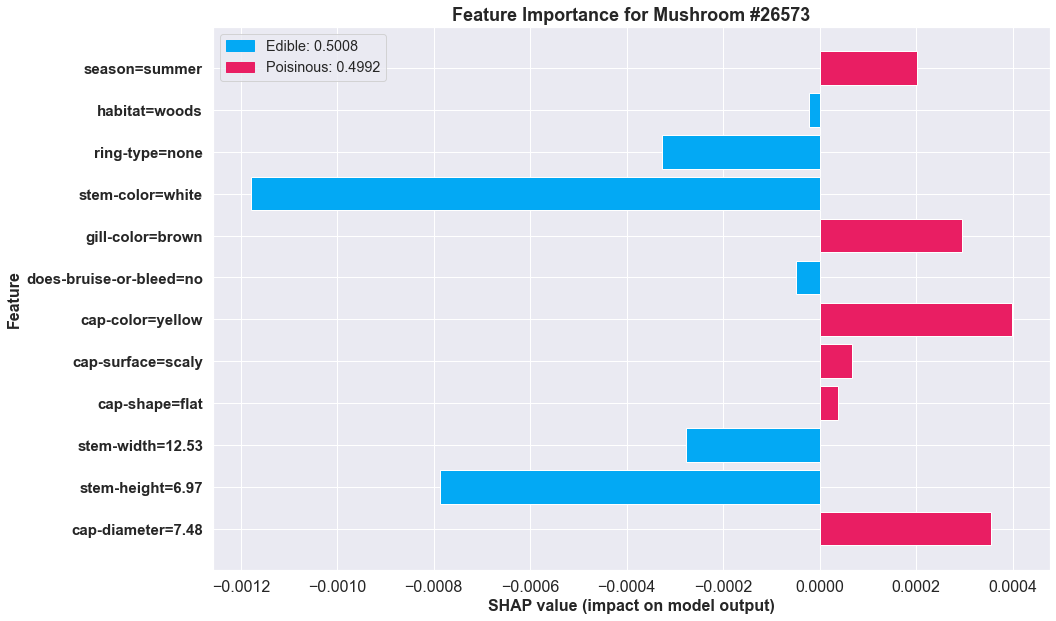

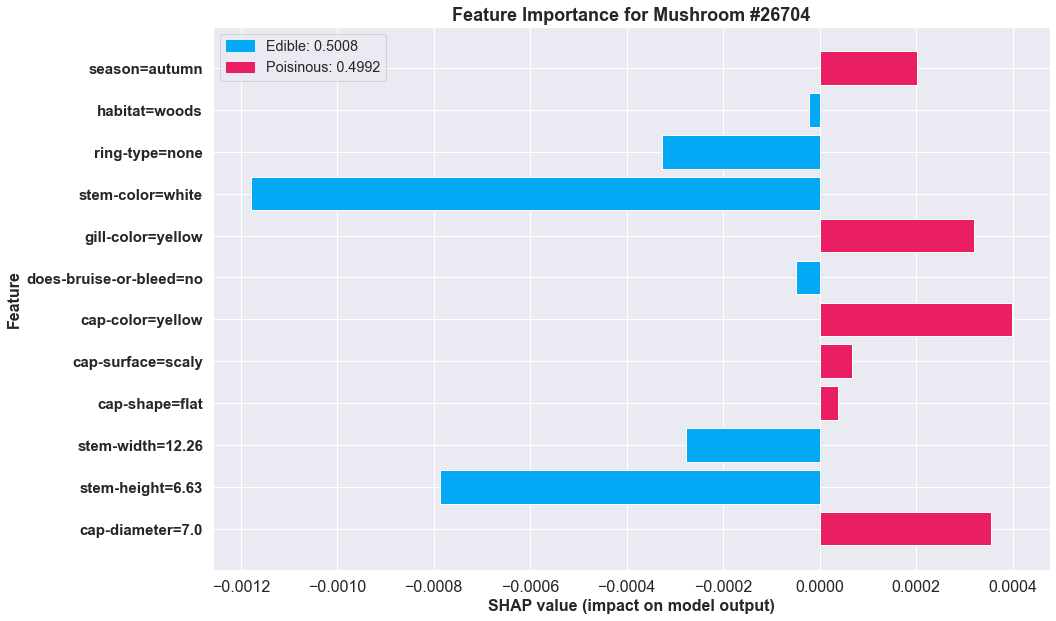

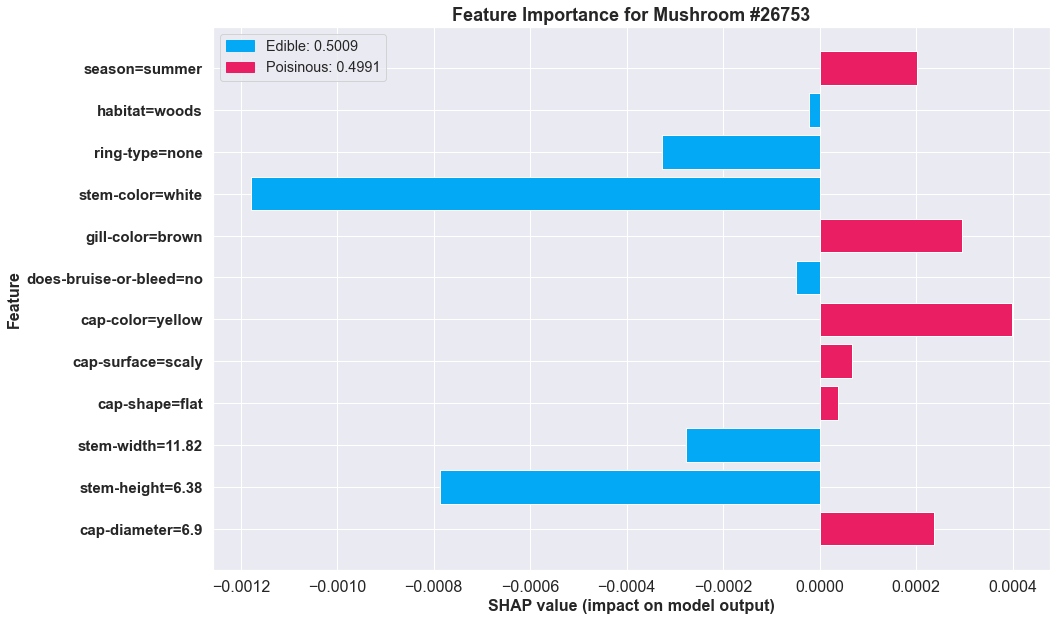

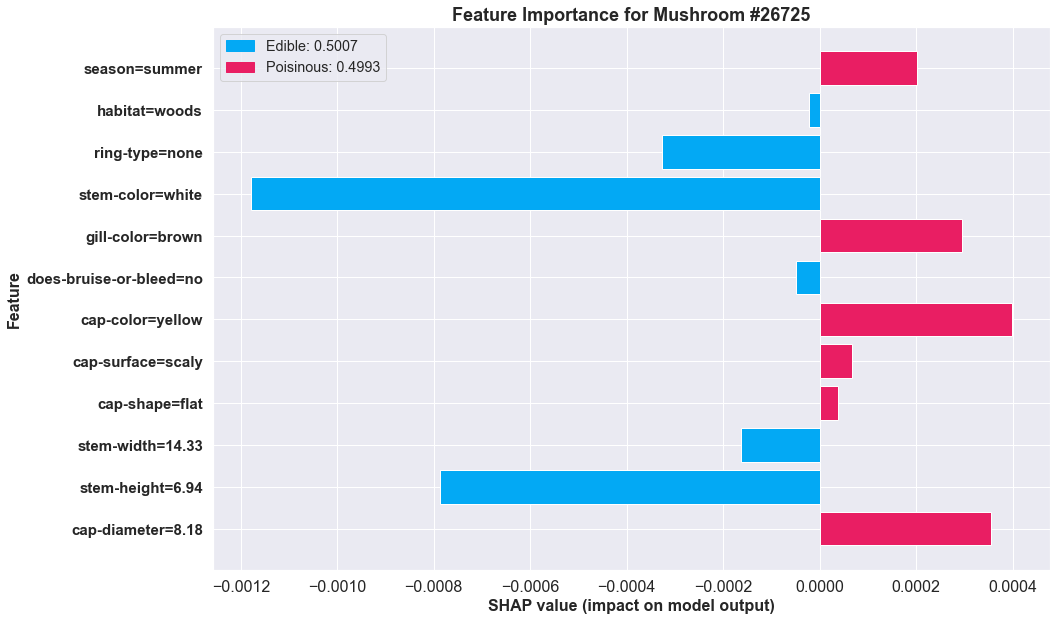

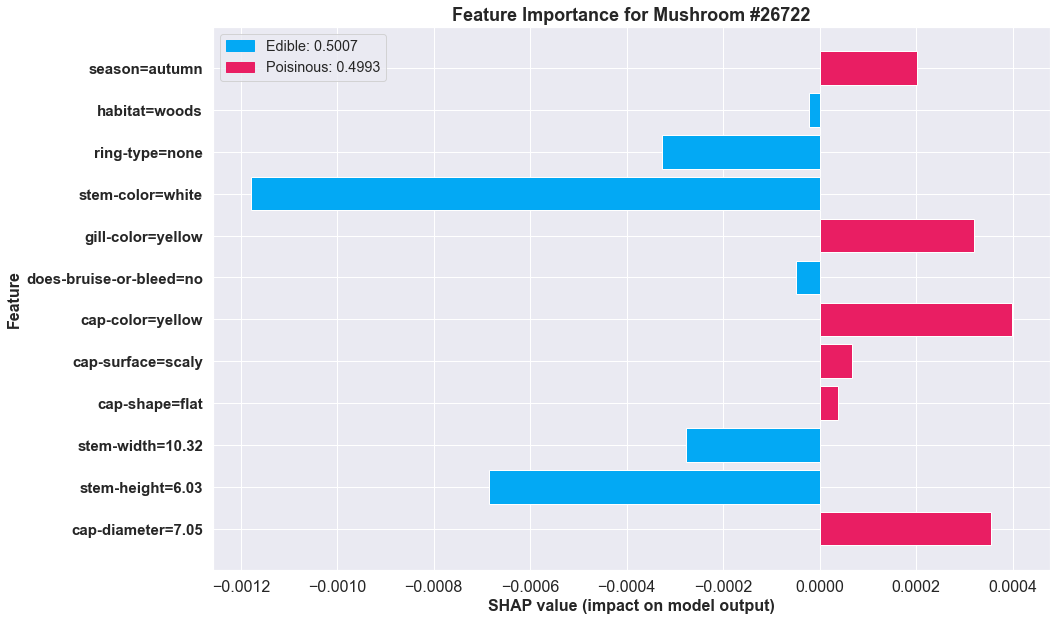

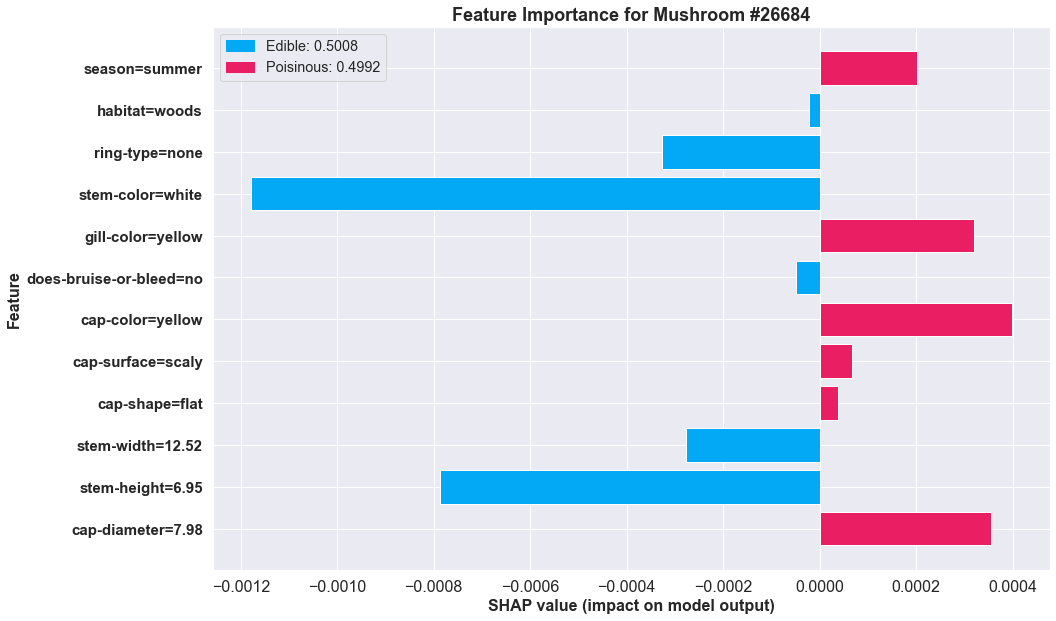

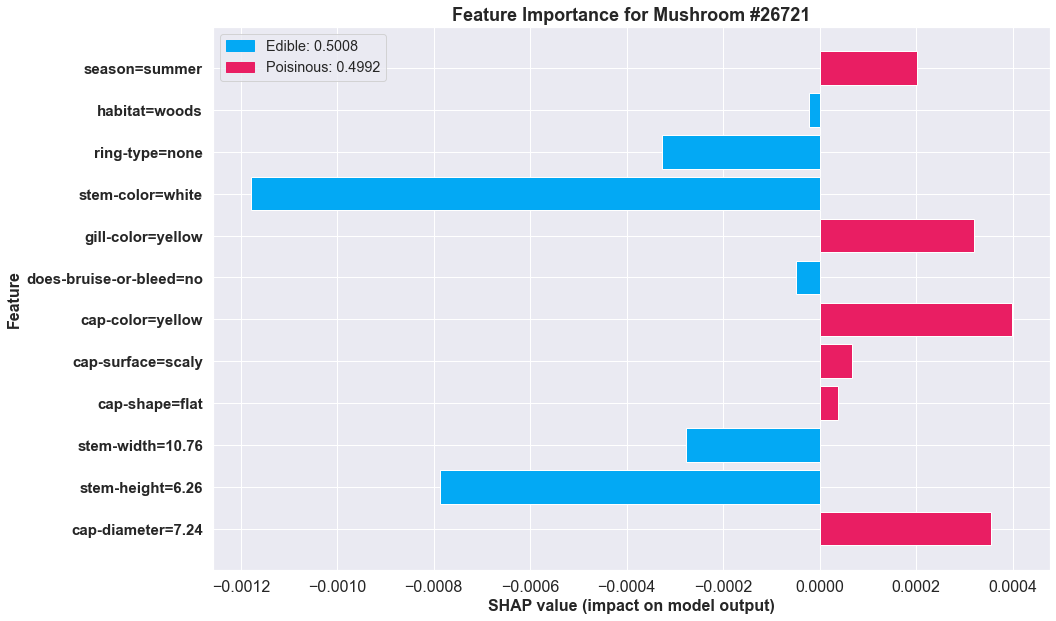

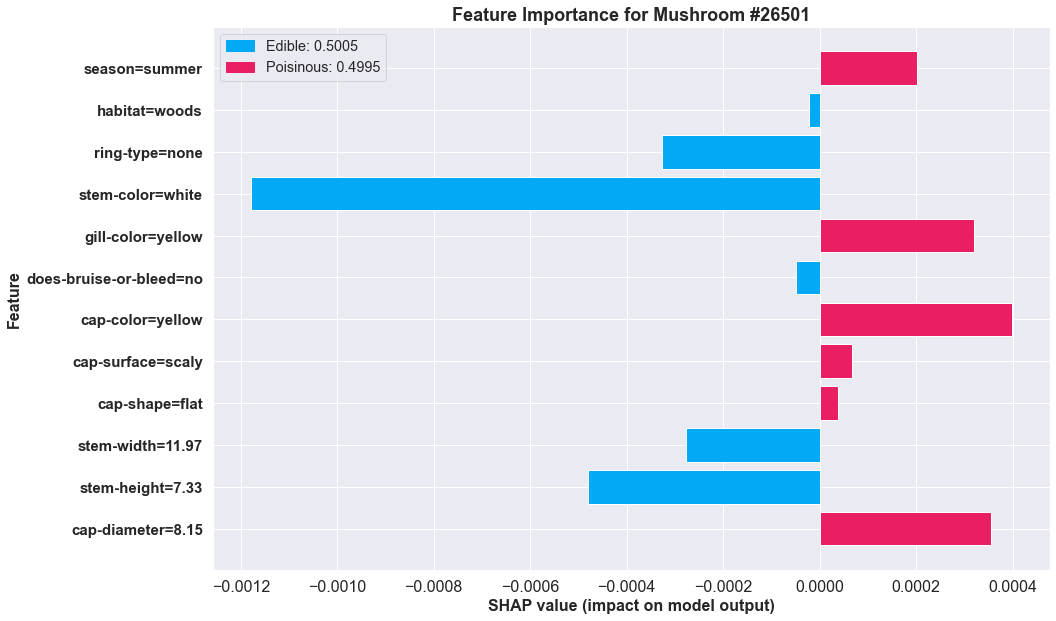

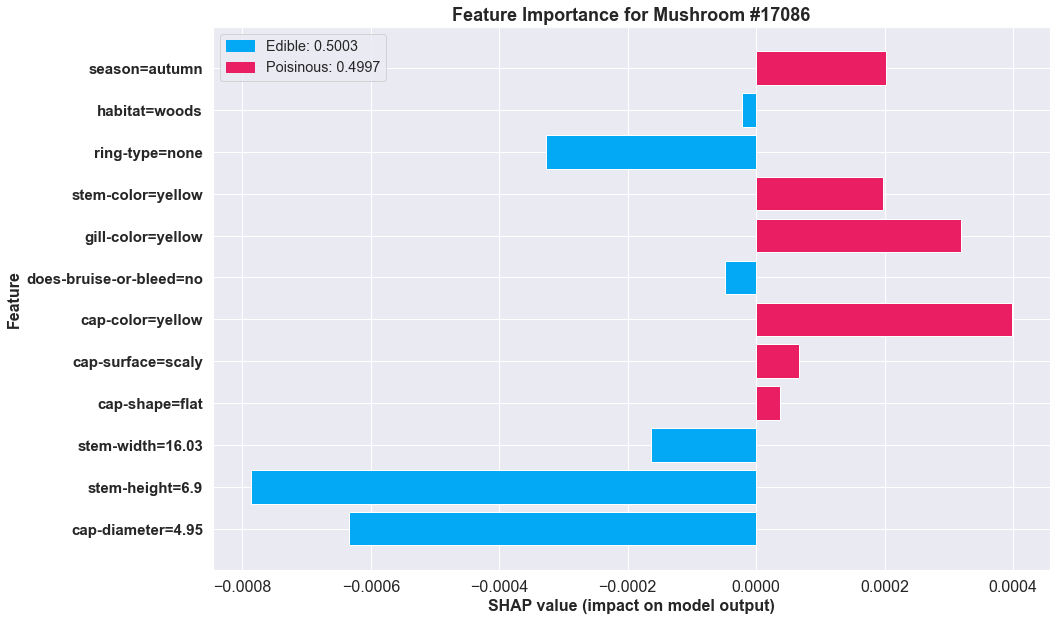

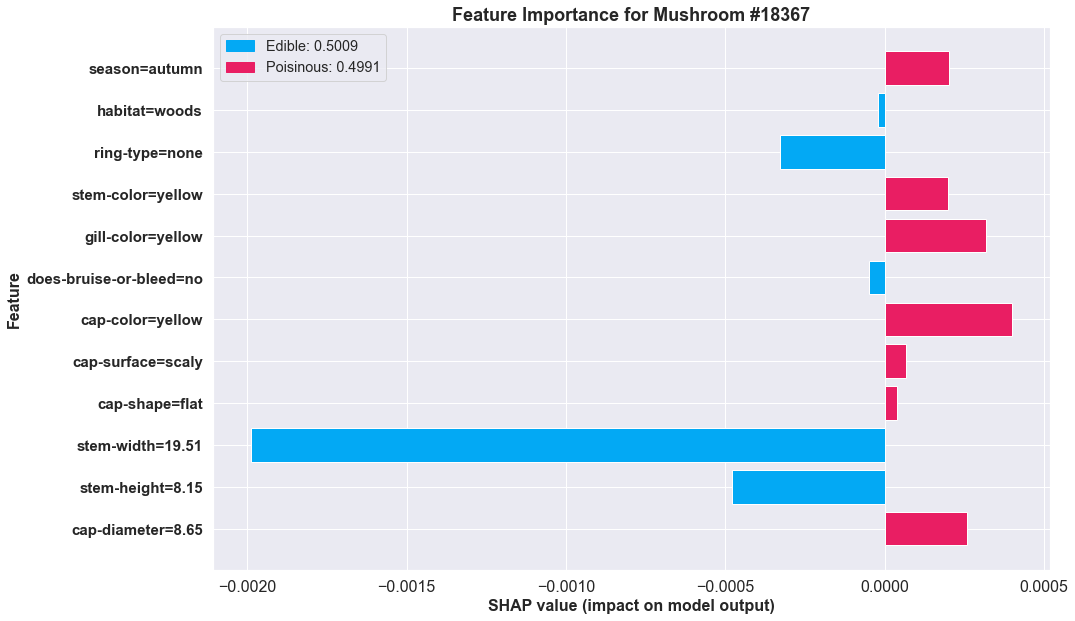

In [39]:
for i in collected_indices:
    plot_feature_importance(i, X_test_feature_importance, probability, main_path)